In [ ]:
import torch
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import seaborn as sns

from torch import Tensor
import math
from typing import Optional
import torch.nn as nn
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Module, Parameter

from torch_geometric.data import Data

from collections import defaultdict
from itertools import combinations

import torch.optim as optim
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    average_precision_score,
    matthews_corrcoef,
    precision_recall_curve,
    auc,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
print(f"PyTorch version: {torch.__version__}")

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    print(f"CUDA runtime version: {torch.version.cuda}")
    print(f"GPU device 0 name: {torch.cuda.get_device_name(0)}")
    print(f"cuDNN available: {torch.backends.cudnn.is_available()}")
    try:
        print(f"cuDNN version: {torch.backends.cudnn.version()}")
    except Exception as e:
        print(f"Could not retrieve cuDNN version: {e}")
else:
    print("CUDA is not available. Computations will run on CPU.")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA runtime version: 12.4
GPU device 0 name: Tesla P100-PCIE-16GB
cuDNN available: True
cuDNN version: 90300


In [ ]:
device = torch.device("cuda" if cuda_available else "cpu")
print(f"Selected device: {device}")

x = torch.rand(3, 3, device=device)
y = torch.rand(3, 3, device=device)
z = x + y
print(f"Tensor operation ran on device: {z.device}")

Selected device: cuda
Tensor operation ran on device: cuda:0


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:0000:01


In [6]:
ls /kaggle/input

healthcare-provider-fraud-detection-analysis/


In [ ]:
label_file_path = "/kaggle/input/healthcare-provider-fraud-detection-analysis/Train-1542865627584.csv"
                    
label_column = "PotentialFraud"

try:
    train_df = pd.read_csv(label_file_path)

    print("Column Names:")
    print(train_df.columns.tolist())
    print("-" * 40)

    if label_column not in train_df.columns:
        raise KeyError(f"ستون '{label_column}' در فایل یافت نشد. لطفاً نام ستون برچسب را بررسی کنید.")

    print(f"بررسی توزیع کلاس‌ها در ستون '{label_column}':")

    
    class_counts = train_df[label_column].value_counts(dropna=False)
    print("\nتعداد نمونه‌ها برای هر کلاس:")
    print(class_counts)
    print("-" * 40)

    
    class_percentages = train_df[label_column].value_counts(normalize=True, dropna=False) * 100
    print("\nدرصد نمونه‌ها برای هر کلاس (%):")
    print(class_percentages.round(2))
    print("-" * 40)

    
    if class_counts.size == 2:
        minority_class_count = class_counts.min()
        majority_class_count = class_counts.max()
        total_samples = class_counts.sum()

        print(f"\nتعداد نمونه‌های کلاس اقلیت: {minority_class_count}")
        print(f"تعداد نمونه‌های کلاس اکثریت: {majority_class_count}")
        print(f"نسبت کلاس اقلیت به کل: {minority_class_count / total_samples:.2%}")
        print(
            f"نسبت کلاس اقلیت به اکثریت: "
            f"{minority_class_count / majority_class_count:.2f} "
            f"(یا 1 به {majority_class_count / minority_class_count:.2f})"
        )

except FileNotFoundError:
    print(f"خطا: فایل '{label_file_path}' یافت نشد. لطفاً مسیر فایل را بررسی کنید.")
except Exception as e:
    print(f"خطای دیگری رخ داده است: {e}")

Column Names:
['Provider', 'PotentialFraud']
----------------------------------------
بررسی توزیع کلاس‌ها در ستون 'PotentialFraud':

تعداد نمونه‌ها برای هر کلاس:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64
----------------------------------------

درصد نمونه‌ها برای هر کلاس (%):
PotentialFraud
No     90.65
Yes     9.35
Name: proportion, dtype: float64
----------------------------------------

تعداد نمونه‌های کلاس اقلیت: 506
تعداد نمونه‌های کلاس اکثریت: 4904
نسبت کلاس اقلیت به کل: 9.35%
نسبت کلاس اقلیت به اکثریت: 0.10 (یا 1 به 9.69)


In [ ]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    
    if hasattr(torch.backends, "cudnn"):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
base_path = "/kaggle/input/healthcare-provider-fraud-detection-analysis"

beneficiary_path = f"{base_path}/Train_Beneficiarydata-1542865627584.csv"
inpatient_path   = f"{base_path}/Train_Inpatientdata-1542865627584.csv"
outpatient_path  = f"{base_path}/Train_Outpatientdata-1542865627584.csv"
labels_path      = f"{base_path}/Train-1542865627584.csv"

try:
    beneficiary_list = pd.read_csv(beneficiary_path)
    inpatient        = pd.read_csv(inpatient_path)
    outpatient       = pd.read_csv(outpatient_path)
    labels           = pd.read_csv(labels_path)

    
    for df in [beneficiary_list, inpatient, outpatient, labels]:
        for col in ["Provider", "BeneID"]:
            if col in df.columns:
                df[col] = df[col].astype(str)

    print("✅ فایل‌ها با موفقیت خوانده شدند.")
    print(f"  Beneficiary shape: {beneficiary_list.shape}")
    print(f"  Inpatient shape:   {inpatient.shape}")
    print(f"  Outpatient shape:  {outpatient.shape}")
    print(f"  Labels shape:      {labels.shape}")
except FileNotFoundError as e:
    raise FileNotFoundError(f"خطا در خواندن فایل‌ها: {e}")

✅ فایل‌ها با موفقیت خوانده شدند.
  Beneficiary shape: (138556, 25)
  Inpatient shape:   (40474, 30)
  Outpatient shape:  (517737, 27)
  Labels shape:      (5410, 2)


In [ ]:
inpatient["ClaimType"]  = "Inpatient"
outpatient["ClaimType"] = "Outpatient"

id_columns = ["BeneID", "ClaimID", "Provider"]
for col in id_columns:
    if col in inpatient.columns:
        inpatient[col] = inpatient[col].astype(str)
    if col in outpatient.columns:
        outpatient[col] = outpatient[col].astype(str)

claims = pd.concat([inpatient, outpatient], ignore_index=True)

claims["ClaimStartDt"] = pd.to_datetime(
    claims["ClaimStartDt"],
    format="%Y-%m-%d",
    errors="coerce"
)

print(f"✅ دیتافریم claims ساخته شد. شکل: {claims.shape}")

✅ دیتافریم claims ساخته شد. شکل: (558211, 31)


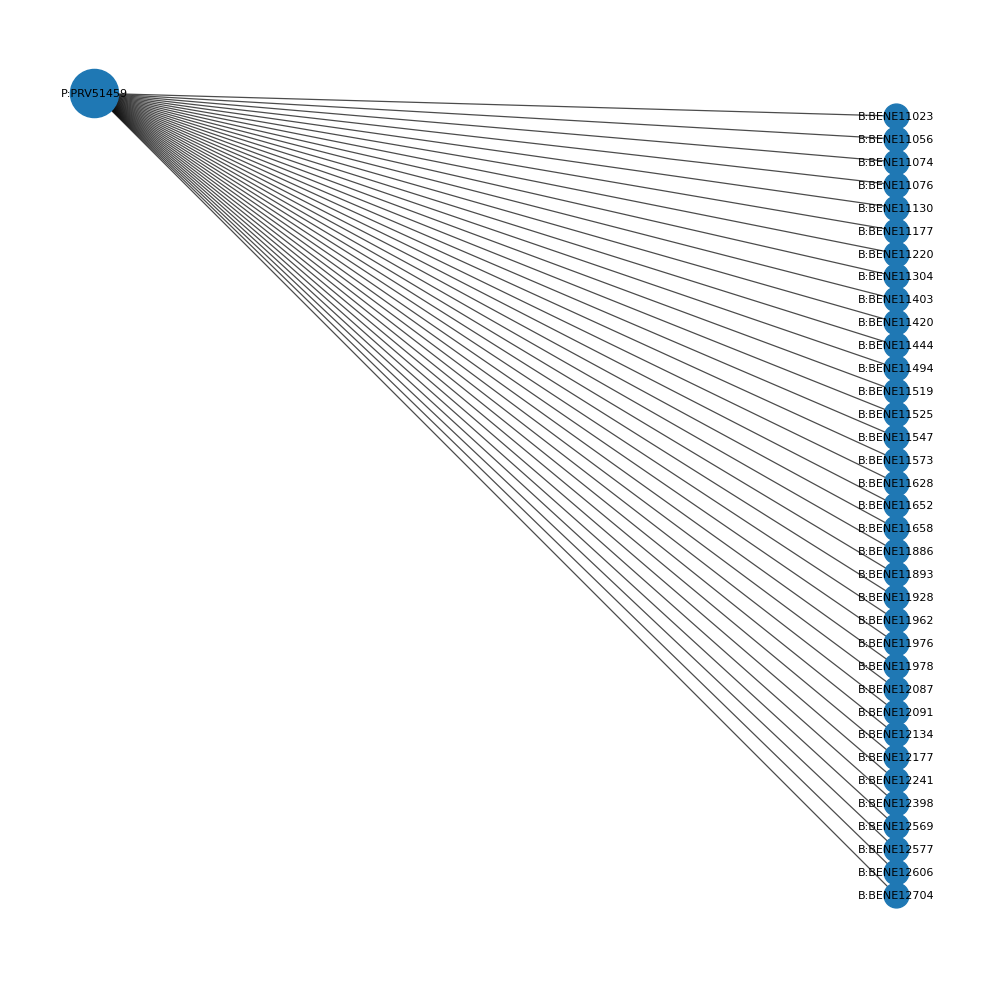

Selected Provider: PRV51459
Saved: fig_bipartite_ego_provider_bene.pdf
Saved: fig_bipartite_ego_provider_bene.png


In [ ]:
def plot_bipartite_provider_bene_ego(
    claims,
    provider_id=None,
    max_benes=40,
    anonymize=True,
    seed=42,
    out_pdf="fig_bipartite_ego_provider_bene.pdf",
    out_png="fig_bipartite_ego_provider_bene.png",
):
    """
    زیرگراف دوبخشی Provider–Beneficiary برای یک Provider منتخب.
    - provider_id: اگر None باشد، به‌صورت خودکار Provider با بیشترین تعداد Beneficiary انتخاب می‌شود.
    - max_benes: تعداد Beneficiary های نمایش داده‌شده (برای خوانایی 20 تا 60 مناسب است)
    - anonymize: برای پایان‌نامه بهتر است True باشد (P1, B1, ...)
    """

    df = claims.copy()
    df["Provider"] = df["Provider"].astype(str)
    df["BeneID"] = df["BeneID"].astype(str)

    if provider_id is None:
        provider_id = (
            df.groupby("Provider")["BeneID"].nunique().sort_values(ascending=False).index[0]
        )

    benes = (
        df.loc[df["Provider"] == provider_id, "BeneID"]
          .dropna()
          .unique()
          .tolist()
    )
    benes = benes[:max_benes]

    P_node = f"P:{provider_id}"
    edges = [(P_node, f"B:{b}") for b in benes]

    G = nx.Graph()
    G.add_edges_from(edges)

    if anonymize:
        mapping = {}
        mapping[P_node] = "P1"
        for i, b in enumerate(benes, start=1):
            mapping[f"B:{b}"] = f"B{i}"
        G = nx.relabel_nodes(G, mapping)
        P_draw = "P1"
        B_draw = [f"B{i}" for i in range(1, len(benes)+1)]
    else:
        P_draw = P_node
        B_draw = [f"B:{b}" for b in benes]

    pos = {}
    pos[P_draw] = (0, 0)
    for i, b in enumerate(B_draw, start=1):
        pos[b] = (1, -i)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, nodelist=[P_draw], node_size=1200)
    nx.draw_networkx_nodes(G, pos, nodelist=B_draw, node_size=320)
    nx.draw_networkx_edges(G, pos, width=0.9, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.axis("off")
    plt.tight_layout()

    plt.savefig(out_pdf, bbox_inches="tight")        
    plt.savefig(out_png, dpi=600, bbox_inches="tight")  
    plt.show()

    print("Selected Provider:", provider_id)
    print("Saved:", out_pdf)
    print("Saved:", out_png)

plot_bipartite_provider_bene_ego(claims, provider_id=None, max_benes=35, anonymize=False)


Top Providers by unique Beneficiary count:
Provider
PRV51459    2857
PRV55215    2638
PRV53797    2020


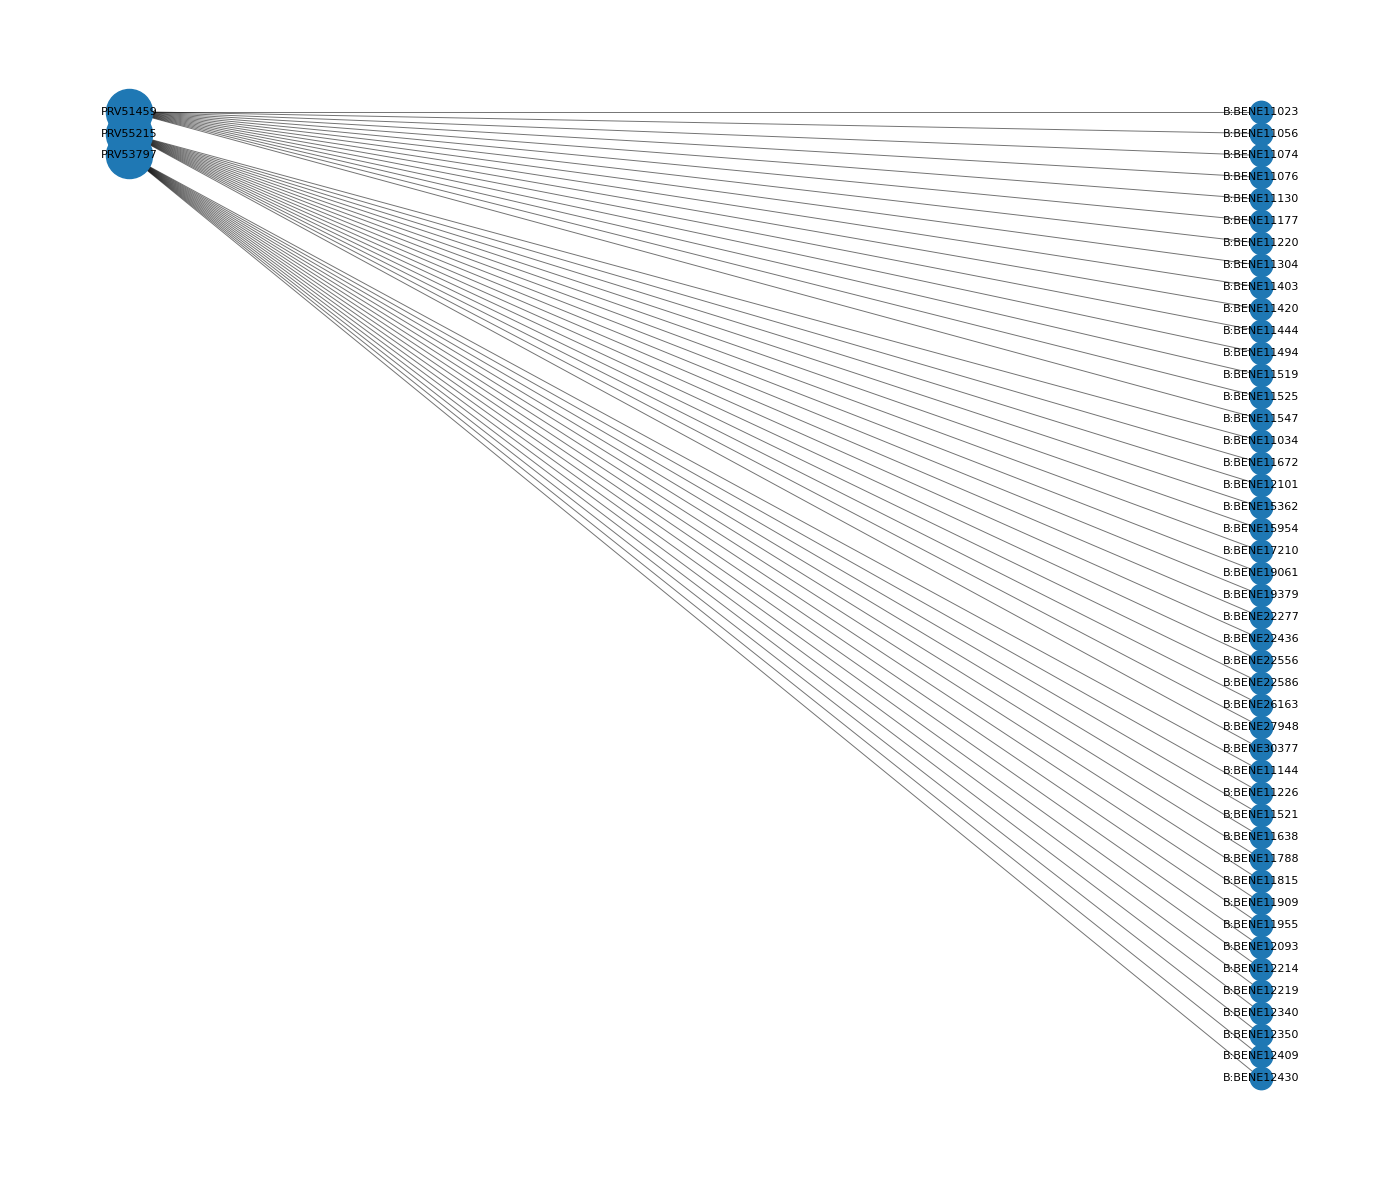

Saved: fig_bipartite_topk_providers.pdf
Saved: fig_bipartite_topk_providers.png


In [ ]:
def plot_bipartite_topk_providers(
    claims,
    k=8,
    max_benes_per_provider=20,
    show_provider_ids=True,
    anonymize_benes=True,
    seed=42,
    out_pdf="fig_bipartite_topk_providers.pdf",
    out_png="fig_bipartite_topk_providers.png",
):
    df = claims.copy()
    df["Provider"] = df["Provider"].astype(str)
    df["BeneID"] = df["BeneID"].astype(str)

    provider_degree = df.groupby("Provider")["BeneID"].nunique().sort_values(ascending=False)
    top_providers = provider_degree.index[:k].tolist()

    print("\nTop Providers by unique Beneficiary count:")
    print(provider_degree.head(k).to_string())

    edges = []
    provider_to_benes = {}
    for p in top_providers:
        benes = (
            df.loc[df["Provider"] == p, "BeneID"]
              .dropna()
              .unique()
              .tolist()
        )
        benes = benes[:max_benes_per_provider]
        provider_to_benes[p] = benes

        p_node = p if show_provider_ids else f"P:{p}"
        edges.extend([(p_node, f"B:{b}") for b in benes])

    G = nx.Graph()
    G.add_edges_from(edges)

    if anonymize_benes:
        all_benes = sorted({b for benes in provider_to_benes.values() for b in benes})
        mapping = {f"B:{b}": f"B{j}" for j, b in enumerate(all_benes, start=1)}
        G = nx.relabel_nodes(G, mapping)

        P_nodes = [p if show_provider_ids else f"P:{p}" for p in top_providers]
        B_nodes = [n for n in G.nodes if n.startswith("B")]
    else:
        P_nodes = [p if show_provider_ids else f"P:{p}" for p in top_providers]
        B_nodes = [n for n in G.nodes if n.startswith("B:")]

    pos = {}
    for i, p in enumerate(P_nodes):
        pos[p] = (0, -i)
    for j, b in enumerate(B_nodes):
        pos[b] = (1, -j)

    plt.figure(figsize=(14, 12))
    nx.draw_networkx_nodes(G, pos, nodelist=P_nodes, node_size=1100)
    nx.draw_networkx_nodes(G, pos, nodelist=B_nodes, node_size=260)
    nx.draw_networkx_edges(G, pos, width=0.7, alpha=0.55)

    label_dict = {p: p for p in P_nodes}
    if len(B_nodes) <= 60:
        label_dict.update({b: b for b in B_nodes})
    nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Saved:", out_pdf)
    print("Saved:", out_png)

plot_bipartite_topk_providers(
    claims,
    k=3,
    max_benes_per_provider=15,
    show_provider_ids=True,
    anonymize_benes=False
)

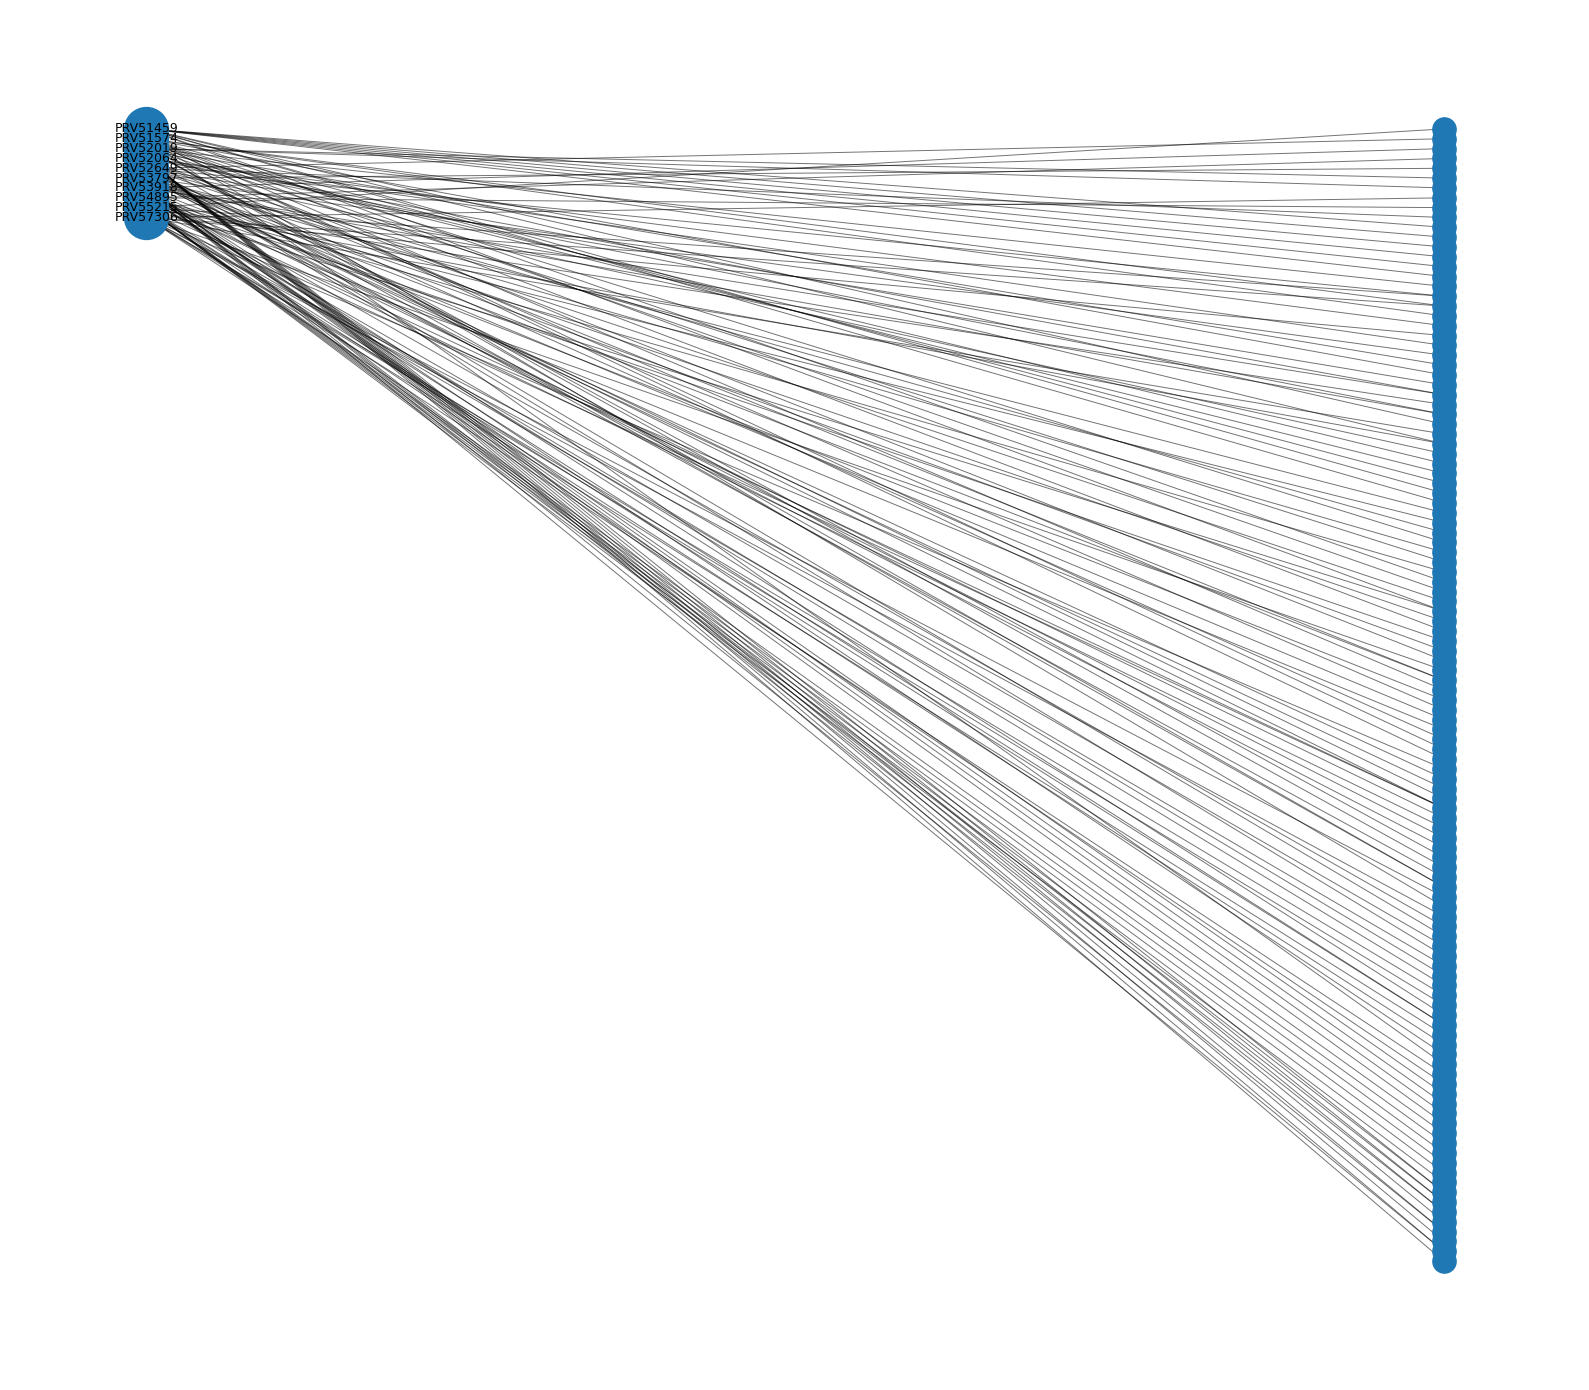

Full graph nodes/edges: 143966 363300
LCC nodes/edges: 143897 363260
Plotted nodes/edges: 126 132
Saved: fig_bipartite_largest_component.pdf
Saved: fig_bipartite_largest_component.png


In [ ]:
def plot_bipartite_largest_component(
    claims,
    max_providers_in_plot=25,
    max_benes_per_provider=15,
    seed=42,
    out_pdf="fig_bipartite_largest_component.pdf",
    out_png="fig_bipartite_largest_component.png",
):
    """
    1) ساخت گراف دوبخشی کامل Provider–Beneficiary
    2) استخراج بزرگ‌ترین کامپوننت همبند (Largest Connected Component)
    3) کوچک‌سازی برای رسم: انتخاب Top providers داخل LCC و محدود کردن Beneficiary ها برای هر Provider
    4) رسم با ID واقعی Provider و Beneficiary
    """

    df = claims.copy()
    df["Provider"] = df["Provider"].astype(str)
    df["BeneID"] = df["BeneID"].astype(str)

    edges = [(f"P:{p}", f"B:{b}") for p, b in zip(df["Provider"], df["BeneID"])]
    G = nx.Graph()
    G.add_edges_from(edges)

    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty. Check claims Provider/BeneID columns.")

    largest_cc_nodes = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc_nodes).copy()

    providers_lcc = [n for n in G_lcc.nodes if n.startswith("P:")]
    bene_lcc      = [n for n in G_lcc.nodes if n.startswith("B:")]

    provider_degrees = sorted(
        [(p, G_lcc.degree(p)) for p in providers_lcc],
        key=lambda x: x[1],
        reverse=True
    )
    keep_providers = [p for p, d in provider_degrees[:max_providers_in_plot]]

    keep_benes = set()
    for p in keep_providers:
        neigh = [n for n in G_lcc.neighbors(p) if n.startswith("B:")]
        neigh = neigh[:max_benes_per_provider]
        keep_benes.update(neigh)

    keep_nodes = set(keep_providers) | keep_benes
    G_plot = G_lcc.subgraph(keep_nodes).copy()

    P_nodes = [n for n in G_plot.nodes if n.startswith("P:")]
    B_nodes = [n for n in G_plot.nodes if n.startswith("B:")]

    P_nodes = sorted(P_nodes)
    B_nodes = sorted(B_nodes)

    pos = {}
    for i, p in enumerate(P_nodes):
        pos[p] = (0, -i)
    for j, b in enumerate(B_nodes):
        pos[b] = (1, -j)

    labels = {}
    for n in G_plot.nodes:
        if n.startswith("P:"):
            labels[n] = n.split("P:")[1]
        else:
            labels[n] = n.split("B:")[1]

    plt.figure(figsize=(16, 14))
    nx.draw_networkx_nodes(G_plot, pos, nodelist=P_nodes, node_size=1000)
    nx.draw_networkx_nodes(G_plot, pos, nodelist=B_nodes, node_size=280)
    nx.draw_networkx_edges(G_plot, pos, width=0.7, alpha=0.55)

    if len(B_nodes) <= 80:
        nx.draw_networkx_labels(G_plot, pos, labels=labels, font_size=7)
    else:
        nx.draw_networkx_labels(
            G_plot, pos,
            labels={p: labels[p] for p in P_nodes},
            font_size=9
        )

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Full graph nodes/edges:", G.number_of_nodes(), G.number_of_edges())
    print("LCC nodes/edges:", G_lcc.number_of_nodes(), G_lcc.number_of_edges())
    print("Plotted nodes/edges:", G_plot.number_of_nodes(), G_plot.number_of_edges())
    print("Saved:", out_pdf)
    print("Saved:", out_png)

plot_bipartite_largest_component(
    claims,
    max_providers_in_plot=10,
    max_benes_per_provider=12
)

In [ ]:
diag_cols = [
    "ClmDiagnosisCode_1",
    "ClmDiagnosisCode_2",
    "ClmDiagnosisCode_3",
    "ClmDiagnosisCode_4", "ClmDiagnosisCode_5",
    "ClmDiagnosisCode_6", "ClmDiagnosisCode_7",
    "ClmDiagnosisCode_8", "ClmDiagnosisCode_9", "ClmDiagnosisCode_10",
]

proc_cols = [
    "ClmProcedureCode_1",
    "ClmProcedureCode_2",
    "ClmProcedureCode_3",
    "ClmProcedureCode_4",
    "ClmProcedureCode_5",
    "ClmProcedureCode_6",
]

all_code_cols = diag_cols + proc_cols

all_code_cols = [c for c in all_code_cols if c in claims.columns]

In [ ]:
claims_long = claims.melt(
    id_vars=["Provider"],
    value_vars=all_code_cols,
    var_name="CodeType",
    value_name="Code"
)

claims_long = claims_long.dropna(subset=["Code"])

In [ ]:
proc_counts = (
    claims_long
    .groupby(["Provider", "Code"])
    .size()
    .unstack(fill_value=0)
)

all_providers = claims["Provider"].dropna().astype(str).unique()
missing_providers = set(all_providers) - set(proc_counts.index)
if missing_providers:
    proc_counts = proc_counts.reindex(proc_counts.index.union(missing_providers), fill_value=0)


print("✅ ماتریس Provider–Code ساخته شد.")
print("   شکل ماتریس (سطر: Provider، ستون: Code):", proc_counts.shape)

In [ ]:
expected_unique_codes = 1325
actual_unique_codes   = proc_counts.shape[1]

print("تعداد واقعی کدهای منحصربه‌فرد در ماتریس:", actual_unique_codes)

if actual_unique_codes != expected_unique_codes:
    print(
        f"⚠️ هشدار: انتظار می‌رفت {expected_unique_codes} کد منحصربه‌فرد وجود داشته باشد، "
        f"اما تعداد فعلی {actual_unique_codes} است."
    )

In [ ]:
if 'claims' not in globals():
    raise ValueError("DataFrame با نام 'claims' در محیط تعریف نشده است.")

if 'proc_counts' not in globals():
    raise ValueError("ماتریس 'proc_counts' (Provider–Code) در محیط تعریف نشده است.")

In [ ]:
proc_counts.columns = proc_counts.columns.astype(str)

scaler_provider = MinMaxScaler()
X_df = pd.DataFrame(
    scaler_provider.fit_transform(proc_counts),
    index=proc_counts.index,
    columns=proc_counts.columns
)

print("✅ نرمال‌سازی ویژگی‌های Provider انجام شد.")
print("   شکل X_df:", X_df.shape)

In [ ]:
if 'BeneID' not in claims.columns:
    raise ValueError("ستون 'BeneID' در DataFrame 'claims' یافت نشد.")

bene_ids_for_indexing = (
    claims['BeneID']
    .dropna()
    .unique()
    .tolist()
)
bene_ids_for_indexing = sorted(bene_ids_for_indexing)

N_Beneficiary = len(bene_ids_for_indexing)
print(f"✅ تعداد کل Beneficiaryهای منحصربه‌فرد برای اندیس‌گذاری (N_Beneficiary): {N_Beneficiary}")

beneficiary_id_map = {
    bene_id: idx for idx, bene_id in enumerate(bene_ids_for_indexing)
}

In [ ]:
BENEFICIARY_CSV_PATH = "/kaggle/input/healthcare-provider-fraud-detection-analysis/Train_Beneficiarydata-1542865627584.csv"

try:
    beneficiary_demographics_df = pd.read_csv(BENEFICIARY_CSV_PATH)
    for col in ["BeneID", "Provider"]:
        if col in beneficiary_demographics_df.columns:
            beneficiary_demographics_df[col] = beneficiary_demographics_df[col].astype(str)
    print(f"✅ فایل دموگرافیک بیمه‌شدگان خوانده شد. شکل: {beneficiary_demographics_df.shape}")
except FileNotFoundError:
    print(f"⚠️ خطا: فایل '{BENEFICIARY_CSV_PATH}' یافت نشد. df_bene_features بدون ویژگی‌های دموگرافیک ساخته می‌شود.")
    beneficiary_demographics_df = pd.DataFrame()

df_bene_features = pd.DataFrame({'BeneID': bene_ids_for_indexing})
df_bene_features["BeneID"] = df_bene_features["BeneID"].astype(str)
print(f"✅ دیتافریم پایه df_bene_features با {len(df_bene_features)} ردیف ایجاد شد.")

demo_cols_from_file = [
    'BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'State', 'County',
    'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
    'ChronicCond_Alzheimer', 'ChronicCond_Asthma', 'ChronicCond_Cancer',
    'ChronicCond_CHF', 'ChronicCond_Depression', 'ChronicCond_Diabetes',
    'ChronicCond_Heartfailure', 'ChronicCond_IschemicHeart', 'ChronicCond_KidneyDisease',
    'ChronicCond_ObstrPulmonary', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
    'ChronicCond_stroke', 'RenalDiseaseIndicator'
]
actual_demo_cols_to_merge = [
    col for col in demo_cols_from_file
    if col in beneficiary_demographics_df.columns
]

if not beneficiary_demographics_df.empty and 'BeneID' in beneficiary_demographics_df.columns:
    beneficiary_demographics_unique = (
        beneficiary_demographics_df[actual_demo_cols_to_merge]
        .drop_duplicates(subset=['BeneID'], keep='first')
    )

    df_bene_features = df_bene_features.merge(
        beneficiary_demographics_unique,
        on='BeneID',
        how='left'
    )
    print("✅ داده‌های دموگرافیک به df_bene_features ادغام شد.")
    print("   شکل df_bene_features:", df_bene_features.shape)
else:
    print("⚠️ هشدار: داده‌های دموگرافیک معتبر یافت نشد؛ ستون‌های دموگرافیک اضافه نمی‌شوند.")
    for col in actual_demo_cols_to_merge:
        if col != 'BeneID' and col not in df_bene_features.columns:
            df_bene_features[col] = np.nan


In [ ]:
latest_claim_date = pd.Timestamp('today')
if 'ClaimEndDt' in claims.columns:
    parsed_dates = pd.to_datetime(claims['ClaimEndDt'], errors='coerce')
    if not parsed_dates.dropna().empty:
        latest_claim_date = parsed_dates.max()

if 'DOB' in df_bene_features.columns:
    df_bene_features['DOB'] = pd.to_datetime(df_bene_features['DOB'], errors='coerce')
    df_bene_features['Age'] = (
        (latest_claim_date - df_bene_features['DOB']).dt.days / 365.25
    )
else:
    df_bene_features['Age'] = np.nan

if 'DOD' in df_bene_features.columns:
    df_bene_features['DOD'] = pd.to_datetime(df_bene_features['DOD'], errors='coerce')
    df_bene_features['IsDeceased'] = df_bene_features['DOD'].notna().astype(int)

    if 'DOB' in df_bene_features.columns:
        valid_mask = df_bene_features['DOD'].notna() & df_bene_features['DOB'].notna()
        df_bene_features.loc[valid_mask, 'Age'] = (
            (df_bene_features.loc[valid_mask, 'DOD'] -
             df_bene_features.loc[valid_mask, 'DOB']).dt.days / 365.25
        )
else:
    df_bene_features['IsDeceased'] = 0

df_bene_features['Age'] = df_bene_features['Age'].round().astype(float)

if 'Gender' in df_bene_features.columns:
    df_bene_features['Gender_transformed'] = df_bene_features['Gender'].map({1: 0, 2: 1})
else:
    df_bene_features['Gender_transformed'] = np.nan

chronic_cols_to_transform = [
    col for col in df_bene_features.columns
    if col.startswith('ChronicCond_')
]
for col in chronic_cols_to_transform:
    new_col = col.replace('ChronicCond_', 'Has_')
    df_bene_features[new_col] = df_bene_features[col].map({
        1: 1,
        2: 0,
        '1': 1,
        '0': 0,
        0: 0
    })

if 'RenalDiseaseIndicator' in df_bene_features.columns:
    df_bene_features['Has_RenalDisease'] = (
        df_bene_features['RenalDiseaseIndicator']
        .map({'Y': 1})
        .fillna(0)
        .astype(int)
    )



agg_funcs = {
    'Provider': ['count', 'nunique'],
    'InscClaimAmtReimbursed': ['sum', 'mean'],
    'DeductibleAmtPaid': ['sum', 'mean'],
    'AttendingPhysician': ['nunique'],
    'OperatingPhysician': ['nunique'],
    'OtherPhysician': ['nunique'],
}

if not claims.empty and 'BeneID' in claims.columns:
    bene_claim_aggregates = claims.groupby('BeneID').agg(agg_funcs)
    bene_claim_aggregates.columns = [
        '_'.join(col).strip() for col in bene_claim_aggregates.columns.values
    ]
    bene_claim_aggregates = bene_claim_aggregates.reset_index()

    df_bene_features = df_bene_features.merge(
        bene_claim_aggregates,
        on='BeneID',
        how='left'
    )
else:
    print("⚠️ هشدار: claims برای تجمیع ویژگی‌ها در دسترس نیست.")
    tmp_cols = [
        'Provider_count', 'Provider_nunique',
        'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
        'DeductibleAmtPaid_sum', 'DeductibleAmtPaid_mean',
        'AttendingPhysician_nunique', 'OperatingPhysician_nunique',
        'OtherPhysician_nunique'
    ]
    for col in tmp_cols:
        if col not in df_bene_features.columns:
            df_bene_features[col] = np.nan

if 'inpatient' in globals() and not inpatient.empty and 'BeneID' in inpatient.columns:
    inpatient_counts = (
        inpatient.groupby('BeneID')
        .size()
        .reset_index(name='NumInpatientClaims')
    )
    df_bene_features = df_bene_features.merge(
        inpatient_counts,
        on='BeneID',
        how='left'
    )
else:
    if 'NumInpatientClaims' not in df_bene_features.columns:
        df_bene_features['NumInpatientClaims'] = np.nan

if 'outpatient' in globals() and not outpatient.empty and 'BeneID' in outpatient.columns:
    outpatient_counts = (
        outpatient.groupby('BeneID')
        .size()
        .reset_index(name='NumOutpatientClaims')
    )
    df_bene_features = df_bene_features.merge(
        outpatient_counts,
        on='BeneID',
        how='left'
    )
else:
    if 'NumOutpatientClaims' not in df_bene_features.columns:
        df_bene_features['NumOutpatientClaims'] = np.nan

In [ ]:
feature_cols_final_selection = [
    'Age', 'IsDeceased', 'Gender_transformed',
    'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
    'Provider_count', 'Provider_nunique',
    'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
    'DeductibleAmtPaid_sum', 'DeductibleAmtPaid_mean',
    'AttendingPhysician_nunique', 'OperatingPhysician_nunique',
    'OtherPhysician_nunique',
    'NumInpatientClaims', 'NumOutpatientClaims',
]

feature_cols_final_selection += [
    col for col in df_bene_features.columns if col.startswith('Has_')
]

actual_feature_cols_for_Xb_final = [
    col for col in feature_cols_final_selection
    if col in df_bene_features.columns and col != 'BeneID'
]

X_b_raw = df_bene_features[actual_feature_cols_for_Xb_final].copy()

for col in X_b_raw.columns:
    if X_b_raw[col].isnull().any():
        if (
            'count' in col or 'nunique' in col or 'sum' in col or 'mean' in col
            or col.startswith('Num') or col.startswith('Has_')
            or col == 'IsDeceased'
        ):
            X_b_raw[col] = X_b_raw[col].fillna(0)
        elif col in ['Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Gender_transformed']:
            median_val = X_b_raw[col].dropna().median()
            if pd.isna(median_val):
                median_val = 0
            X_b_raw[col] = X_b_raw[col].fillna(median_val)
        else:
            X_b_raw[col] = X_b_raw[col].fillna(0)

X_b_raw = X_b_raw.astype(float)

In [ ]:
if not X_b_raw.empty:
    scaler_beneficiary = MinMaxScaler()
    X_b_scaled_np = scaler_beneficiary.fit_transform(X_b_raw)

    X_b_df = pd.DataFrame(
        X_b_scaled_np,
        columns=X_b_raw.columns,
        index=df_bene_features.index
    )
    print("✅ نرمال‌سازی ویژگی‌های Beneficiary انجام شد.")
    print("   شکل X_b_df:", X_b_df.shape)
else:
    print("⚠️ X_b_raw خالی است؛ X_b_df به‌صورت دیتافریم خالی با همان اندیس ساخته شد.")
    X_b_df = pd.DataFrame(index=df_bene_features.index)

In [ ]:
print("=" * 70)
print("شروع فرآیند انتخاب ویژگی برای گره‌های بیمار (Beneficiary)...")

NUM_TOP_FEATURES = 15 
FEATURES_TO_REMOVE_FOR_EXPERIMENT = ['Provider_count', 'Provider_nunique']  # آزمایش استاد

required_vars = ['X_b_df', 'df_bene_features', 'labels', 'claims']
for var_name in required_vars:
    if var_name not in globals():
        raise ValueError(
            f"متغیر '{var_name}' در محیط فعلی تعریف نشده است. "
            f"لطفاً قبل از اجرای این سلول، سلول‌های آماده‌سازی داده را اجرا کنید."
        )

if 'BeneID' not in df_bene_features.columns:
    raise ValueError("ستون 'BeneID' در df_bene_features وجود ندارد.")

for col in ['Provider', 'PotentialFraud']:
    if col not in labels.columns:
        raise ValueError(f"ستون '{col}' در DataFrame برچسب‌ها (labels) وجود ندارد.")

for col in ['BeneID', 'Provider']:
    if col not in claims.columns:
        raise ValueError(f"ستون '{col}' در DataFrame claims وجود ندارد.")


labels["Provider"] = labels["Provider"].astype(str)
claims["Provider"] = claims["Provider"].astype(str)
claims["BeneID"] = claims["BeneID"].astype(str)
df_bene_features["BeneID"] = df_bene_features["BeneID"].astype(str)

labels_clean = (
    labels[['Provider', 'PotentialFraud']]
    .dropna(subset=['Provider', 'PotentialFraud'])
    .drop_duplicates(subset=['Provider'], keep='first')
)

provider_labels_series = labels_clean.set_index('Provider')['PotentialFraud'].map({
    'Yes': 1,
    'No': 0
})

provider_labels_series = provider_labels_series.dropna().astype(int)
provider_labels_map = provider_labels_series.to_dict()

print(f"تعداد Providerهایی که برچسب معتبر دارند: {provider_labels_series.shape[0]}")

if provider_labels_series.empty:
    raise ValueError("هیچ Provider با برچسب معتبر (Yes/No) یافت نشد.")

In [ ]:
selected_beneficiary_features = list(X_b_df.columns)

print("✅ بدون انتخاب ویژگی نظارت‌شده؛ از تمام ویژگی‌های Beneficiary استفاده می‌شود.")
print(f"تعداد ویژگی‌ها: {len(selected_beneficiary_features)}")
print("نمونه‌ای از ویژگی‌ها:")
print(selected_beneficiary_features[:20])
print("=" * 70)

In [ ]:
if 'claims' not in globals():
    raise ValueError("DataFrame 'claims' تعریف نشده است. ابتدا داده‌های claims را بارگذاری کنید.")

required_cols = {'Provider', 'BeneID'}
missing_cols = required_cols - set(claims.columns)
if missing_cols:
    raise ValueError(f"ستون‌های {missing_cols} در DataFrame 'claims' وجود ندارند.")

provider_ids = claims['Provider'].dropna().unique()
provider_ids_sorted = np.sort(provider_ids)

if 'bene_ids_for_indexing' in globals() and len(bene_ids_for_indexing) > 0:
    beneficiary_ids_sorted = np.array(sorted(bene_ids_for_indexing))
else:
    beneficiary_ids = claims['BeneID'].dropna().unique()
    beneficiary_ids_sorted = np.sort(beneficiary_ids)
    bene_ids_for_indexing = beneficiary_ids_sorted.tolist()  # برای استفاده در مراحل بعدی

provider_id_map = {pid: i for i, pid in enumerate(provider_ids_sorted)}
beneficiary_id_map = {bid: i for i, bid in enumerate(beneficiary_ids_sorted)}

N_Provider = len(provider_ids_sorted)
N_Beneficiary = len(beneficiary_ids_sorted)

print(f"تعداد Providerهای منحصربه‌فرد: {N_Provider}")
print(f"تعداد Beneficiaryهای منحصربه‌فرد: {N_Beneficiary}")

In [ ]:
pb_claims = (
    claims[['Provider', 'BeneID']]
    .dropna(subset=['Provider', 'BeneID'])
    .drop_duplicates()  
    .copy()
)

pb_claims['provider_idx'] = pb_claims['Provider'].map(provider_id_map)
pb_claims['bene_idx'] = pb_claims['BeneID'].map(beneficiary_id_map)

pb_claims = pb_claims.dropna(subset=['provider_idx', 'bene_idx']).copy()

pb_claims['provider_idx'] = pb_claims['provider_idx'].astype(int)
pb_claims['bene_idx'] = pb_claims['bene_idx'].astype(int)

unique_provider_beneficiary_pairs = set(
    zip(pb_claims['provider_idx'].to_numpy(), pb_claims['bene_idx'].to_numpy())
)

print(f"تعداد تعاملات منحصربه‌فرد Provider–Beneficiary: {len(unique_provider_beneficiary_pairs)}")

edge_index_provider_bene = torch.tensor(
    np.vstack([
        pb_claims['provider_idx'].to_numpy(),
        pb_claims['bene_idx'].to_numpy()
    ]),
    dtype=torch.long
)

print("edge_index_provider_bene shape:", tuple(edge_index_provider_bene.shape))

In [ ]:
if 'claims' not in globals():
    raise ValueError(
        "DataFrame 'claims' در محیط فعلی موجود نیست. "
        "ابتدا داده‌های Inpatient و Outpatient را ادغام کرده و در claims ذخیره کن."
    )

required_cols = {'Provider', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'}
missing_cols = required_cols - set(claims.columns)
if missing_cols:
    raise ValueError(f"ستون‌های {missing_cols} در DataFrame 'claims' وجود ندارند.")


providers_in_claims = claims['Provider'].dropna().unique()

if 'provider_id_map' in globals():
    known_providers = set(provider_id_map.keys())
    missing_providers = set(providers_in_claims) - known_providers

    if missing_providers:
        raise ValueError(
            f"{len(missing_providers)} Provider در provider_id_map موجود نیست. "
            f"نمونه‌ای از Providerهای جدید: {list(missing_providers)[:5]}"
        )
    provider_ids_sorted = np.array(sorted(known_providers))
else:
    provider_ids_sorted = np.sort(providers_in_claims)
    provider_id_map = {pid: i for i, pid in enumerate(provider_ids_sorted)}

N_Provider = len(provider_id_map)
print(f"تعداد Providerهای منحصربه‌فرد در نگاشت: {N_Provider}")


physician_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']


provider_provider_weights = defaultdict(int)


for col in physician_cols:
    if col not in claims.columns:
        print(f"هشدار: ستون '{col}' در claims وجود ندارد و نادیده گرفته می‌شود.")
        continue

    phys_claims_filtered = claims.dropna(subset=[col, 'Provider'])

    grouped_by_phys = phys_claims_filtered.groupby(col)['Provider'].unique()
    print(f"تعداد پزشکان منحصربه‌فرد در ستون '{col}': {len(grouped_by_phys)}")

    for providers_for_phys_list in grouped_by_phys:
        if len(providers_for_phys_list) <= 1:
            continue

        mapped_indices = [
            provider_id_map[p_orig_id]
            for p_orig_id in providers_for_phys_list
            if p_orig_id in provider_id_map
        ]

        if len(mapped_indices) <= 1:
            continue

        for p1_idx, p2_idx in combinations(sorted(mapped_indices), 2):
            provider_provider_weights[(p1_idx, p2_idx)] += 1

In [ ]:
def plot_provider_provider_ego_from_weights(
    provider_provider_weights,
    provider_ids_sorted,
    center_provider=None,
    min_weight=2,
    max_neighbors=25,
    seed=42,
    out_pdf="fig_provider_provider_ego.pdf",
    out_png="fig_provider_provider_ego.png",
):
    """
    Ego subgraph برای گراف Provider–Provider وزن‌دار بر اساس پزشک مشترک.
    - provider_provider_weights: دیکشنری {(p1_idx, p2_idx): weight}
    - provider_ids_sorted: آرایه‌ای که index -> ProviderID را مشخص می‌کند
    """

    G = nx.Graph()
    for (p1_idx, p2_idx), w in provider_provider_weights.items():
        w = float(w)
        if w < min_weight:
            continue
        p1 = str(provider_ids_sorted[int(p1_idx)])
        p2 = str(provider_ids_sorted[int(p2_idx)])
        G.add_edge(p1, p2, weight=w)

    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty after applying min_weight. Reduce min_weight or check weights.")

    if center_provider is None:
        center_provider = max(G.degree, key=lambda x: x[1])[0]
    else:
        center_provider = str(center_provider)
        if center_provider not in G:
            raise ValueError(f"center_provider={center_provider} not found in graph (after filtering).")

    neighbors = list(G.neighbors(center_provider))
    if len(neighbors) > max_neighbors:
        neighbors = sorted(neighbors, key=lambda n: G[center_provider][n]["weight"], reverse=True)[:max_neighbors]

    H = G.subgraph([center_provider] + neighbors).copy()

    pos = nx.spring_layout(H, seed=seed, k=0.9)
    weights = [H[u][v]["weight"] for u, v in H.edges()]
    edge_widths = [0.6 + 0.25*w for w in weights]

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(H, pos, nodelist=[center_provider], node_size=1400)
    nx.draw_networkx_nodes(H, pos, nodelist=[n for n in H.nodes if n != center_provider], node_size=700)
    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=8)

    edge_labels = {(u, v): int(H[u][v]["weight"]) for u, v in H.edges()}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Provider–Provider Ego Subgraph (center={center_provider}, min_weight={min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Center provider:", center_provider)
    print("Nodes/Edges in ego subgraph:", H.number_of_nodes(), H.number_of_edges())
    print("Saved:", out_pdf)
    print("Saved:", out_png)

plot_provider_provider_ego_from_weights(
    provider_provider_weights=provider_provider_weights,
    provider_ids_sorted=provider_ids_sorted,
    center_provider=None,
    min_weight=2,
    max_neighbors=25
)

In [ ]:
def build_provider_provider_graph_from_weights(provider_provider_weights, provider_ids_sorted, min_weight=2):
    G = nx.Graph()
    for (p1_idx, p2_idx), w in provider_provider_weights.items():
        w = float(w)
        if w < min_weight:
            continue
        p1 = str(provider_ids_sorted[int(p1_idx)])
        p2 = str(provider_ids_sorted[int(p2_idx)])
        G.add_edge(p1, p2, weight=w)
    return G

def plot_provider_provider_topk(
    provider_provider_weights,
    provider_ids_sorted,
    k=30,
    min_weight=2,
    ranking="strength",
    seed=42,
    out_pdf="fig_provider_provider_topk.pdf",
    out_png="fig_provider_provider_topk.png",
):
    """
    زیرگراف Provider–Provider برای Top-k Provider.
    ranking:
      - "degree": بیشترین تعداد همسایه
      - "strength": بیشترین مجموع وزن یال‌ها (weighted degree)
    """

    G = build_provider_provider_graph_from_weights(
        provider_provider_weights=provider_provider_weights,
        provider_ids_sorted=provider_ids_sorted,
        min_weight=min_weight
    )

    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty after applying min_weight. Reduce min_weight or check weights.")

    if ranking == "degree":
        scores = {n: G.degree(n) for n in G.nodes()}
    elif ranking == "strength":
        scores = {n: sum(G[n][nbr]["weight"] for nbr in G.neighbors(n)) for n in G.nodes()}
    else:
        raise ValueError('ranking must be "degree" or "strength"')

    top_nodes = [n for n, s in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

    print(f"\nTop-{k} providers by {ranking} (min_weight={min_weight}):")
    for i, n in enumerate(top_nodes, start=1):
        print(f"{i:>2}. {n}  |  score={scores[n]}")

    H = G.subgraph(top_nodes).copy()

    pos = nx.spring_layout(H, seed=seed, k=0.8)

    weights = [H[u][v]["weight"] for u, v in H.edges()]
    edge_widths = [0.6 + 0.20*w for w in weights]

    plt.figure(figsize=(13, 11))
    nx.draw_networkx_nodes(H, pos, node_size=650)
    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=7)

    if H.number_of_edges() <= 80:
        edge_labels = {(u, v): int(H[u][v]["weight"]) for u, v in H.edges()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=6)

    plt.title(f"Provider–Provider Top-{k} Subgraph (ranking={ranking}, min_weight={min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Subgraph nodes/edges:", H.number_of_nodes(), H.number_of_edges())
    print("Saved:", out_pdf)
    print("Saved:", out_png)


plot_provider_provider_topk(
    provider_provider_weights=provider_provider_weights,
    provider_ids_sorted=provider_ids_sorted,
    k=25,
    min_weight=2,
    ranking="strength"
)

In [ ]:
def build_provider_provider_graph_from_weights(provider_provider_weights, provider_ids_sorted, min_weight=2):
    G = nx.Graph()
    for (p1_idx, p2_idx), w in provider_provider_weights.items():
        w = float(w)
        if w < min_weight:
            continue
        p1 = str(provider_ids_sorted[int(p1_idx)])
        p2 = str(provider_ids_sorted[int(p2_idx)])
        G.add_edge(p1, p2, weight=w)
    return G

def plot_provider_provider_lcc(
    provider_provider_weights,
    provider_ids_sorted,
    min_weight=3,
    max_nodes_in_plot=80,
    reduce_by="strength",
    seed=42,
    out_pdf="fig_provider_provider_lcc.pdf",
    out_png="fig_provider_provider_lcc.png",
):
    """
    1) ساخت گراف Provider–Provider با threshold وزن
    2) استخراج Largest Connected Component
    3) اگر بزرگ بود، کاهش اندازه برای نمایش
    """

    G = build_provider_provider_graph_from_weights(
        provider_provider_weights=provider_provider_weights,
        provider_ids_sorted=provider_ids_sorted,
        min_weight=min_weight
    )

    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty after applying min_weight. Reduce min_weight or check weights.")

    lcc_nodes = max(nx.connected_components(G), key=len)
    H = G.subgraph(lcc_nodes).copy()

    print("Full graph nodes/edges:", G.number_of_nodes(), G.number_of_edges())
    print("LCC nodes/edges:", H.number_of_nodes(), H.number_of_edges())

    if H.number_of_nodes() > max_nodes_in_plot:
        if reduce_by == "degree":
            scores = {n: H.degree(n) for n in H.nodes()}
        elif reduce_by == "strength":
            scores = {n: sum(H[n][nbr]["weight"] for nbr in H.neighbors(n)) for n in H.nodes()}
        else:
            raise ValueError('reduce_by must be "degree" or "strength"')

        keep_nodes = [n for n, s in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:max_nodes_in_plot]]
        H = H.subgraph(keep_nodes).copy()
        print(f"Reduced for plotting -> nodes/edges: {H.number_of_nodes()}, {H.number_of_edges()} (by {reduce_by})")

    pos = nx.spring_layout(H, seed=seed, k=0.9)

    weights = [H[u][v]["weight"] for u, v in H.edges()]
    edge_widths = [0.6 + 0.18*w for w in weights]

    plt.figure(figsize=(14, 12))
    nx.draw_networkx_nodes(H, pos, node_size=600)
    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=7)

    if H.number_of_edges() <= 90:
        edge_labels = {(u, v): int(H[u][v]["weight"]) for u, v in H.edges()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=6)

    plt.title(f"Provider–Provider Largest Connected Component (min_weight={min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Saved:", out_pdf)
    print("Saved:", out_png)

plot_provider_provider_lcc(
    provider_provider_weights=provider_provider_weights,
    provider_ids_sorted=provider_ids_sorted,
    min_weight=5,
    max_nodes_in_plot=80,
    reduce_by="strength"
)

In [ ]:
num_edges = len(provider_provider_weights)
print(f"\n✅ تعداد یال‌های وزن‌دار Provider-Provider (بر اساس پزشک مشترک): {num_edges}")

sorted_weights = sorted(
    provider_provider_weights.items(),
    key=lambda item: item[1],
    reverse=True
)

print("نمونه ۵ یال با بیشترین وزن (قوی‌ترین ارتباط‌ها):")
for (p1_idx, p2_idx), weight in sorted_weights[:5]:
    print(f"  - زوج Provider با اندیس ({p1_idx}, {p2_idx}): {weight} پزشک مشترک")

provider_provider_edges_df = pd.DataFrame(
    [
        (p1_idx, p2_idx, w)
        for (p1_idx, p2_idx), w in provider_provider_weights.items()
    ],
    columns=['ProviderIdx_1', 'ProviderIdx_2', 'Weight']
)

print("\nنمونه‌ای از جدول یال‌های Provider-Provider:")
print(provider_provider_edges_df.head())

In [ ]:
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device به صورت خودکار روی {device} تنظیم شد.")
else:
    print(f"از device موجود استفاده می‌شود: {device}")


required_vars = ['N_Provider', 'N_Beneficiary',
                 'unique_provider_beneficiary_pairs',
                 'provider_provider_weights']
for var_name in required_vars:
    if var_name not in globals():
        raise ValueError(f"متغیر '{var_name}' در محیط فعلی تعریف نشده است. "
                         f"لطفاً سلول‌های قبلی را اجرا کن.")

unique_provider_beneficiary_pairs = {
    (int(p), int(b)) for (p, b) in unique_provider_beneficiary_pairs
}


A_provider_beneficiary = torch.zeros(
    (N_Provider, N_Beneficiary),
    dtype=torch.float32,
    device=device
)

for p_idx, b_idx in unique_provider_beneficiary_pairs:
    if 0 <= p_idx < N_Provider and 0 <= b_idx < N_Beneficiary:
        A_provider_beneficiary[p_idx, b_idx] = 1.0

num_edges_pb = int(A_provider_beneficiary.sum().item())


deg_p = A_provider_beneficiary.sum(dim=1, keepdim=True)  
deg_p = deg_p.clamp(min=1.0)                             
A_provider_beneficiary = A_provider_beneficiary / deg_p

row_sums_example = A_provider_beneficiary.sum(dim=1)[:5].detach().cpu().numpy()
print(f"  نمونه‌ای از مجموع سطرهای نرمال‌شده (A_pb): {row_sums_example}")

print("✅ A_provider_beneficiary ساخته شد:")
print(f"  شکل (shape): {tuple(A_provider_beneficiary.shape)}  روی دستگاه: {A_provider_beneficiary.device}")
print(f"  تعداد یال‌های Provider–Beneficiary (تعداد عناصر ۱ در ماتریس): {num_edges_pb}")
print("-" * 70)

In [ ]:
A_pp_phys = torch.zeros(
    (N_Provider, N_Provider),
    dtype=torch.float32,
    device=device
)

for (p1_idx, p2_idx), weight in provider_provider_weights.items():
    p1_idx = int(p1_idx)
    p2_idx = int(p2_idx)
    w = float(weight)

    if 0 <= p1_idx < N_Provider and 0 <= p2_idx < N_Provider:
        A_pp_phys[p1_idx, p2_idx] = w
        A_pp_phys[p2_idx, p1_idx] = w  

if len(provider_provider_weights) > 0:
    max_weight = A_pp_phys.max()
    if max_weight > 0:
        A_pp_phys = A_pp_phys / max_weight
        print(f"وزن‌های A_pp_phys با تقسیم بر حداکثر وزن ({max_weight.item():.0f}) نرمال‌سازی شدند.")
else:
    print("هشدار: provider_provider_weights خالی است؛ A_pp_phys صفر باقی می‌ماند.")

num_nonzero_pp = int((A_pp_phys > 0).sum().item())

print("✅ A_pp_phys (گراف Provider–Provider بر اساس پزشک مشترک) ساخته شد:")
print(f"  شکل (shape): {tuple(A_pp_phys.shape)}  روی دستگاه: {A_pp_phys.device}")
print(f"  تعداد عناصر غیر صفر (یال‌های موجود): {num_nonzero_pp}")
if num_nonzero_pp > 0:
    print(f"  بیشترین مقدار (بعد از نرمال‌سازی): {A_pp_phys.max().item():.4f}")
    print(f"  میانگین مقادیر غیر صفر: {A_pp_phys[A_pp_phys > 0].mean().item():.4f}")
print("-" * 70)

In [ ]:
A_input_for_gtn_layers = A_pp_phys.unsqueeze(0)

print("✅ A_input_for_gtn_layers (ورودی روابط Provider–Provider برای GTN):")
print(f"  شکل (shape): {tuple(A_input_for_gtn_layers.shape)}")
print(f"  دستگاه (device): {A_input_for_gtn_layers.device}")
print("-" * 70)


if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device به‌صورت خودکار روی {device} تنظیم شد.")
else:
    print(f"از device موجود استفاده می‌شود: {device}")



if 'X_df' not in globals():
    raise ValueError("X_df در محیط فعلی تعریف نشده است (ماتریس ویژگی‌های Provider).")

if not isinstance(X_df, pd.DataFrame):
    raise TypeError("X_df باید یک DataFrame از pandas باشد.")

if 'provider_list' not in globals():
    if 'provider_id_map' in globals():
        provider_list = sorted(provider_id_map.keys())
        print("provider_list بر اساس provider_id_map ساخته شد.")
    else:
        provider_list = sorted(X_df.index.unique())
        print("provider_list بر اساس اندیس‌های X_df ساخته شد.")

N_Provider = len(provider_list)

missing_providers = set(provider_list) - set(X_df.index)
if missing_providers:
    raise ValueError(
        f"{len(missing_providers)} Provider در X_df وجود ندارند. "
        f"نمونه: {list(missing_providers)[:5]}"
    )

X_p_ordered_df = X_df.reindex(provider_list)

if X_p_ordered_df.isnull().any().any():
    print(
        "هشدار: در X_p_ordered_df مقادیر NaN وجود دارد. "
        "بهتر است قبل از این مرحله، مقادیر گمشده را پر/نرمال‌سازی کنید."
    )

X_p = torch.tensor(
    X_p_ordered_df.to_numpy(),
    dtype=torch.float32,
    device=device
)

print("✅ تنسور ویژگی‌های Provider (X_p) ساخته شد.")
print(f"   شکل (shape): {tuple(X_p.shape)}   روی دستگاه: {X_p.device}")
print("-" * 70)

In [ ]:
if 'X_b_df' not in globals():
    raise ValueError("X_b_df در محیط فعلی تعریف نشده است (ماتریس ویژگی‌های Beneficiary).")

if not isinstance(X_b_df, pd.DataFrame):
    raise TypeError("X_b_df باید یک DataFrame از pandas باشد.")


if 'bene_ids_for_indexing' in globals() and isinstance(bene_ids_for_indexing, list):
    beneficiary_list = bene_ids_for_indexing
    print("beneficiary_list بر اساس bene_ids_for_indexing تنظیم شد.")
elif 'beneficiary_list' in globals():
    beneficiary_list = beneficiary_list
else:
    beneficiary_list = None

if beneficiary_list is not None:
    if X_b_df.shape[0] != len(beneficiary_list):
        print(
            f"هشدار: تعداد ردیف‌های X_b_df ({X_b_df.shape[0]}) "
            f"با طول beneficiary_list ({len(beneficiary_list)}) برابر نیست."
        )
        print("در صورت نیاز می‌توانید X_b_df را بر اساس BeneID مجدداً مرتب کنید.")
else:
    print(
        "توجه: beneficiary_list تعریف نشده است؛ فرض می‌کنیم ترتیب ردیف‌های X_b_df "
        "با ترتیب استفاده‌شده در ساخت ماتریس‌های مجاورت Beneficiary هم‌خوان است."
    )

X_b = torch.tensor(
    X_b_df.to_numpy(),
    dtype=torch.float32,
    device=device
)

print("✅ تنسور ویژگی‌های Beneficiary (X_b) ساخته شد.")
print(f"   شکل (shape): {tuple(X_b.shape)}   روی دستگاه: {X_b.device}")
print("-" * 70)



if 'labels' not in globals():
    raise ValueError("labels در محیط فعلی تعریف نشده است (DataFrame برچسب‌ها).")

if not isinstance(labels, pd.DataFrame):
    raise TypeError("labels باید یک DataFrame از pandas باشد.")

required_cols = {'Provider', 'PotentialFraud'}
if not required_cols.issubset(labels.columns):
    raise ValueError(
        f"ستون‌های {required_cols} باید در DataFrame برچسب‌ها (labels) وجود داشته باشند."
    )

y_series = (
    labels
    .set_index('Provider')
    .loc[provider_list, 'PotentialFraud']
    .map({'Yes': 1, 'No': 0})
)

if y_series.isnull().any():
    num_nan = y_series.isnull().sum()
    raise ValueError(
        f"{num_nan} مقدار برچسب نامعتبر (NaN) در y_series وجود دارد. "
        f"احتمالاً مقدار غیر از 'Yes'/'No' در PotentialFraud ثبت شده است."
    )

y = torch.tensor(
    y_series.to_numpy(),
    dtype=torch.float32,
    device=device
)

print("✅ تنسور برچسب‌ها (y) برای Providerها ساخته شد.")
print(f"   شکل (shape): {tuple(y.shape)}   روی دستگاه: {y.device}")
print(f"   تعداد نمونه‌های مثبت (تقلب): {int(y.sum().item())}")
print(f"   تعداد کل نمونه‌ها: {y.size(0)}")
print("-" * 70)

In [ ]:
class EarlyStopping:
    """
    مکانیزم توقف زودهنگام (Early Stopping) برای آموزش مدل.

    منطق:
    - بهترین مقدار loss اعتبارسنجی (val_loss) مشاهده‌شده را در طول آموزش نگه می‌دارد.
    - اگر برای چند epoch متوالی (به اندازه‌ی `patience`) بهبودی در loss مشاهده نشود
      و مقدار جدید بیشتر از (best_loss + tol) باشد، پرچم `early_stop` را True می‌کند.
    - در هر بار بهبود، وزن‌های مدل را در مسیر `save_path` ذخیره می‌کند.

    پارامترها
    ----------
    patience : int
        حداکثر تعداد epochهایی که بدون بهبود قابل قبول در val_loss اجازه می‌دهیم ادامه یابد.
    tol : float
        آستانه‌ی حداقلی برای بهبود. اگر val_loss جدید حداقل به اندازه‌ی tol بهتر باشد،
        به‌عنوان بهبود پذیرفته می‌شود.
    save_path : str
        مسیری که بهترین وزن‌های مدل در آن ذخیره می‌شوند.
    """

    def __init__(self, patience: int = 10, tol: float = 1e-4,
                 save_path: str = "checkpoint.pt") -> None:
        self.patience: int = patience
        self.tol: float = tol
        self.save_path: str = save_path

        self.counter: int = 0
        self.best_loss: Optional[float] = None
        self.early_stop: bool = False

    def __call__(self, val_loss, model: nn.Module) -> None:
        """
        به‌روزرسانی وضعیت توقف زودهنگام با توجه به val_loss جدید.

        Parameters
        ----------
        val_loss : float یا torch.Tensor
            مقدار loss روی مجموعه‌ی اعتبارسنجی در این epoch.
        model : torch.nn.Module
            مدل PyTorch که در صورت بهبود، وزن‌های آن ذخیره می‌شود.
        """
        if isinstance(val_loss, torch.Tensor):
            current_loss = float(val_loss.detach().cpu().item())
        else:
            current_loss = float(val_loss)

        if math.isnan(current_loss) or math.isinf(current_loss):
            print("هشدار: مقدار val_loss نامعتبر (NaN/Inf) است؛ EarlyStopping این مقدار را نادیده گرفت.")
            return

        if self.best_loss is None:
            self.best_loss = current_loss
            self._save_checkpoint(model)
            return

        if current_loss > self.best_loss + self.tol:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = current_loss
            self._save_checkpoint(model)
            self.counter = 0

    def _save_checkpoint(self, model: nn.Module) -> None:
        """
        ذخیره‌ی وزن‌های فعلی مدل در مسیر تعیین‌شده.
        """
        torch.save(model.state_dict(), self.save_path)

In [ ]:
def get_symmetrically_normalized_matrix(A: torch.Tensor) -> torch.Tensor:
    """
    نرمال‌سازی متقارن ماتریس مجاورت برای استفاده در GCN/GTN:

        A_norm = D^{-1/2} (A + I) D^{-1/2}

    ویژگی‌ها:
    - به‌طور خودکار self-loop به همه گره‌ها اضافه می‌کند.
    - برای گره‌های با درجه‌ صفر، از ایجاد NaN/Inf جلوگیری می‌کند.
    - خروجی روی همان device و با همان dtype (float) برگردانده می‌شود.

    Parameters
    ----------
    A : torch.Tensor
        ماتریس مجاورت (N × N)، ۲بعدی و مربعی.

    Returns
    -------
    torch.Tensor
        ماتریس مجاورت نرمال‌شده متقارن با ابعاد (N × N).
    """
    if A.dim() != 2 or A.size(0) != A.size(1):
        raise ValueError(f"A must be a square 2D tensor, got shape {tuple(A.shape)}")

    if not torch.is_floating_point(A):
        A = A.to(dtype=torch.float32)

    N = A.size(0)

    A_tilde = A + torch.eye(N, device=A.device, dtype=A.dtype)

    D_tilde = A_tilde.sum(dim=1)

    D_tilde_safe = torch.clamp_min(D_tilde, 1e-12)
    D_inv_sqrt = torch.pow(D_tilde_safe, -0.5)

    D_inv_sqrt_mat = torch.diag(D_inv_sqrt)

    A_norm = D_inv_sqrt_mat @ A_tilde @ D_inv_sqrt_mat

    return A_norm

In [ ]:
class GTNLayer(Module):
    """
    GTNLayer:
        برای هر کانال c:
            A_meta^c = sum_r w_{c,r} * A_r

    Parameters
    ----------
    num_relations : int
        تعداد انواع رابطه (تعداد ماتریس‌های مجاورت اولیه، R).
    num_channels : int
        تعداد کانال‌های متا-مسیر (C).
    """
    def __init__(self, num_relations: int, num_channels: int) -> None:
        super().__init__()
        self.num_relations = num_relations
        self.num_channels = num_channels

        self.weights = Parameter(torch.empty(num_channels, num_relations))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.xavier_uniform_(self.weights)

    def forward(self, A_stack: Tensor) -> Tensor:
        """
        Parameters
        ----------
        A_stack : Tensor
            تنسور 3بعدی با شکل (R, N, N)، R=تعداد روابط، N=تعداد گره‌ها.

        Returns
        -------
        Tensor
            A_meta با شکل (C, N, N)، C=تعداد کانال‌ها.
        """
        if A_stack.dim() != 3:
            raise ValueError(f"A_stack must be 3D (R, N, N), got shape {tuple(A_stack.shape)}")
        R, N1, N2 = A_stack.shape
        if N1 != N2:
            raise ValueError(f"A_stack must be square on last two dims, got {N1}x{N2}")
        if R != self.num_relations:
            raise ValueError(
                f"A_stack first dim (R={R}) must match num_relations={self.num_relations}"
            )

        w = torch.softmax(self.weights, dim=1)         
        w = w.unsqueeze(-1).unsqueeze(-1)              

        
        a_s = A_stack.unsqueeze(0)                     

        
        A_meta = torch.sum(w * a_s, dim=1)
        return A_meta

In [ ]:
class GCNConv(Module):
    """
    یک لایه ساده GCN:

        H' = A_norm * H_in * W

    Parameters
    ----------
    in_features : int
        بعد ورودی هر گره (F_in).
    out_features : int
        بعد خروجی هر گره (F_out).
    """
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.linear = Linear(in_features, out_features)

    def forward(self, A_norm: Tensor, H_in: Tensor) -> Tensor:
        """
        Parameters
        ----------
        A_norm : Tensor
            ماتریس مجاورت نرمال‌شده (N, N).
        H_in : Tensor
            ویژگی‌های ورودی گره‌ها (N, F_in).

        Returns
        -------
        Tensor
            ویژگی‌های خروجی گره‌ها (N, F_out).
        """
        if A_norm.dim() != 2:
            raise ValueError(f"A_norm must be 2D (N, N), got shape {tuple(A_norm.shape)}")
        if H_in.dim() != 2:
            raise ValueError(f"H_in must be 2D (N, F_in), got shape {tuple(H_in.shape)}")
        if A_norm.size(0) != A_norm.size(1):
            raise ValueError("A_norm must be square (N, N).")
        if A_norm.size(0) != H_in.size(0):
            raise ValueError(
                f"A_norm and H_in must have same N; got {A_norm.size(0)} and {H_in.size(0)}"
            )

        H_agg = A_norm @ H_in       
        H_out = self.linear(H_agg)
        return H_out

In [ ]:
class GTN(Module):
    """
    مدل GTN برای طبقه‌بندی Providerها (متقلب / غیرمتقلب).

    Pipeline:
      1) GTNLayerها: یادگیری متا-گراف‌های Provider-Provider از روی روابط اولیه P-P
      2) GCN روی متا-گراف‌ها برای استخراج embedding Provider
      3) فشرده‌سازی ویژگی Beneficiary و پیام‌رسانی به Provider (A_pb * H_b)
      4) MLP نهایی برای طبقه‌بندی

    Parameters
    ----------
    num_pp_relations : int
        تعداد روابط اولیه P-P در A_pp_relations_stack (R).
    num_channels : int
        تعداد کانال‌های متا-گراف (C).
    in_features_provider : int
        بعد اولیه ویژگی Provider (X_p).
    provider_initial_hidden_dim : int
        بعد لایه خطی اولیه Provider.
    gcn_hidden_dim : int
        بعد خروجی هر لایه GCN.
    in_features_beneficiary : int
        بعد اولیه ویژگی Beneficiary (X_b).
    beneficiary_hidden_dim : int
        بعد embedding بیمه‌شدگان.
    final_fc_hidden_dim : int
        بعد لایه میانی در MLP.
    num_classes : int
        تعداد کلاس‌ها (برای مسئله باینری معمولاً 1).
    num_gtn_layers : int, default=2
        عمق GTN (تعداد لایه‌های متوالی GTNLayer).
    num_gcn_layers : int, default=1
        تعداد لایه‌های GCN روی گراف نهایی.
    dropout_rate : float, default=0.6
        نرخ دراپ‌اوت در MLP نهایی.
    """
    def __init__(
        self,
        num_pp_relations: int,
        num_channels: int,
        in_features_provider: int,
        provider_initial_hidden_dim: int,
        gcn_hidden_dim: int,
        in_features_beneficiary: int,
        beneficiary_hidden_dim: int,
        final_fc_hidden_dim: int,
        num_classes: int,
        num_gtn_layers: int = 2,
        num_gcn_layers: int = 1,
        dropout_rate: float = 0.6,
    ) -> None:
        super().__init__()

        self.num_pp_relations = num_pp_relations
        self.num_gtn_layers = num_gtn_layers
        self.num_gcn_layers = num_gcn_layers
        self.num_channels = num_channels

        self.linear_provider = Linear(in_features_provider, provider_initial_hidden_dim)
        self.linear_beneficiary = Linear(in_features_beneficiary, beneficiary_hidden_dim)

        self.gt_layers = nn.ModuleList(
            [GTNLayer(num_pp_relations, num_channels) for _ in range(num_gtn_layers)]
        )

        self.gcn_layers = nn.ModuleList()
        for i in range(num_gcn_layers):
            in_dim = provider_initial_hidden_dim if i == 0 else gcn_hidden_dim
            self.gcn_layers.append(GCNConv(in_dim, gcn_hidden_dim))

        fc1_input_dim = (num_channels * gcn_hidden_dim) + beneficiary_hidden_dim
        self.fc1 = Linear(fc1_input_dim, final_fc_hidden_dim)
        self.fc2 = Linear(final_fc_hidden_dim, num_classes)

        self.dropout = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()

    def forward(
        self,
        X_p: Tensor,                    
        X_b: Tensor,                    
        A_pp_relations_stack: Tensor,   
        A_provider_beneficiary: Tensor  
    ) -> Tensor:
        
        N_p, F_p = X_p.shape
        N_b, F_b = X_b.shape

        if A_pp_relations_stack.dim() != 3:
            raise ValueError(
                f"A_pp_relations_stack must be 3D (R, N_p, N_p), got {tuple(A_pp_relations_stack.shape)}"
            )
        R, N1, N2 = A_pp_relations_stack.shape
        if R != self.num_pp_relations:
            raise ValueError(
                f"First dim of A_pp_relations_stack (R={R}) must match num_pp_relations={self.num_pp_relations}"
            )
        if N1 != N2 or N1 != N_p:
            raise ValueError(
                f"Inconsistent dimensions: A_pp_relations_stack is (R,{N1},{N2}), "
                f"X_p is ({N_p},{F_p})"
            )
        if A_provider_beneficiary.shape != (N_p, N_b):
            raise ValueError(
                f"A_provider_beneficiary must be (N_provider, N_beneficiary) = ({N_p},{N_b}), "
                f"got {tuple(A_provider_beneficiary.shape)}"
            )

        
        Q_matrices = [gtn_layer(A_pp_relations_stack) for gtn_layer in self.gt_layers]

        A_final_channels = Q_matrices[0]  
        if self.num_gtn_layers > 1:
            for i in range(1, self.num_gtn_layers):
                
                A_final_channels = torch.bmm(A_final_channels, Q_matrices[i])

        
        H_p_initial = self.relu(self.linear_provider(X_p))  

        H_p_gcn_outputs_per_channel = []
        for c_idx in range(self.num_channels):
            A_c = A_final_channels[c_idx]

            
            A_c_norm = get_symmetrically_normalized_matrix(A_c)

            H_c = H_p_initial
            for gcn_layer in self.gcn_layers:
                H_c = self.relu(gcn_layer(A_c_norm, H_c))
            H_p_gcn_outputs_per_channel.append(H_c)

        H_p_after_gcn = torch.cat(H_p_gcn_outputs_per_channel, dim=1)

        
        H_b = self.relu(self.linear_beneficiary(X_b))           
        Msg_b_to_p = A_provider_beneficiary @ H_b               

        H_p_combined = torch.cat([H_p_after_gcn, Msg_b_to_p], dim=1)

        
        hidden = self.relu(self.fc1(H_p_combined))
        hidden = self.dropout(hidden)
        logits = self.fc2(hidden)

        return logits

In [ ]:
class FocalLoss(nn.Module):
    """
    Focal Loss برای طبقه‌بندی باینری با خروجی logits.

    Parameters
    ----------
    alpha : float
        ضریب توازن کلاس‌ها (بین 0 و 1). برای داده‌ی نامتوازن معمولاً 0.25 نقطه‌ی شروع خوبی است.
    gamma : float
        پارامتر تمرکز (focusing parameter). هرچه بزرگ‌تر، تمرکز بیش‌تر روی نمونه‌های سخت.
        اگر gamma = 0 باشد، این تابع معادل BCEWithLogitsLoss معمولی می‌شود.
    reduction : {"none", "mean", "sum"}
        نوع تجمیع روی زیان نمونه‌ها.
    eps : float
        عدد بسیار کوچک برای جلوگیری از مسائل عددی (مانند log(0) یا exp overflow).
    """
    def __init__(
        self,
        alpha: float = 0.25,
        gamma: float = 2.0,
        reduction: str = "mean",
        eps: float = 1e-8,
    ) -> None:
        super().__init__()

        if reduction not in {"none", "mean", "sum"}:
            raise ValueError("reduction must be 'none', 'mean', or 'sum'.")

        self.alpha: float = float(alpha)
        self.gamma: float = float(gamma)
        self.reduction: str = reduction
        self.eps: float = float(eps)

    def forward(self, inputs: Tensor, targets: Tensor) -> Tensor:
        """
        Parameters
        ----------
        inputs : Tensor
            logits مدل، با شکل (N,) یا (N, 1) (قابل broadcast با targets).
        targets : Tensor
            برچسب‌های باینری (0 یا 1)، هم‌شکل با inputs (broadcast-safe).

        Returns
        -------
        Tensor
            مقدار Focal Loss (اسکالر اگر reduction != "none").
        """
        targets = targets.to(dtype=inputs.dtype)

        bce_loss = F.binary_cross_entropy_with_logits(
            inputs,
            targets,
            reduction="none",
        )  

        p_t = torch.exp(-bce_loss)
        p_t = p_t.clamp(min=self.eps, max=1.0 - self.eps)

        focal_loss = (1.0 - p_t) ** self.gamma * bce_loss

        
        alpha_t = targets * self.alpha + (1.0 - targets) * (1.0 - self.alpha)
        focal_loss = alpha_t * focal_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
provider_initial_hidden_dims = [16, 32]
num_channels_list = [2, 4]
learning_rates = [0.001, 0.005]
regularization_list = [0.0005, 0.001]

gcn_hidden_dim_fixed = 64
num_gcn_layers_fixed = 1
beneficiary_hidden_dim_fixed = 16
num_gtn_layers_fixed = 2
dropout_rate_fixed = 0.6

max_epochs = 200
patience_es = 15

results_log = []
best_f1 = -np.inf
best_params_combination = None


if "A_input_for_gtn_layers" not in globals() or A_input_for_gtn_layers is None:
    raise ValueError("A_input_for_gtn_layers تعریف نشده است.")

if A_input_for_gtn_layers.dim() != 3:
    raise ValueError(
        f"A_input_for_gtn_layers باید ۳ بعدی باشد، اما شکل فعلی {tuple(A_input_for_gtn_layers.shape)} است."
    )

num_pp_relations_runtime = A_input_for_gtn_layers.shape[0]
print(f"تعداد روابط Provider-Provider (num_pp_relations_runtime): {num_pp_relations_runtime}")

if num_pp_relations_runtime == 0:
    raise ValueError("A_input_for_gtn_layers دارای صفر رابطه است (shape[0] == 0).")



y_cpu = y.detach().cpu().long().numpy()
num_samples = y_cpu.shape[0]

X_p_cpu = X_p.detach().cpu()
if X_p_cpu.shape[0] != num_samples:
    raise ValueError(
        f"تعداد ردیف‌های X_p ({X_p_cpu.shape[0]}) با طول y ({num_samples}) برابر نیست."
    )

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)



for p_init_hidden_dim in provider_initial_hidden_dims:
    final_fc_dim = p_init_hidden_dim

    for num_ch in num_channels_list:
        for lr_val in learning_rates:
            for wd_val in regularization_list:


                run_id = f"p{p_init_hidden_dim}_ch{num_ch}_lr{lr_val}_wd{wd_val}"
                checkpoint_template = f"best_gtn_{run_id}_fold_{{}}.pt"


                current_hyperparams = {
                    "provider_initial_hidden_dim": p_init_hidden_dim,
                    "num_channels": num_ch,
                    "gcn_hidden_dim": gcn_hidden_dim_fixed,
                    "num_gcn_layers": num_gcn_layers_fixed,
                    "beneficiary_hidden_dim": beneficiary_hidden_dim_fixed,
                    "final_fc_hidden_dim": final_fc_dim,
                    "num_gtn_layers": num_gtn_layers_fixed,
                    "dropout_rate": dropout_rate_fixed,
                    "lr": lr_val,
                    "wd": wd_val,
                    "num_pp_relations": num_pp_relations_runtime,
                }

                print("\n" + "-" * 70)
                print(f"شروع آموزش با هایپرپارامترها:")
                print(f"run_id = {run_id}")
                for k_param, v_param in current_hyperparams.items():
                    print(f"  {k_param}: {v_param}")

                oof_probs = np.zeros(num_samples, dtype=float)

                
                for fold, (train_idx, val_idx) in enumerate(
                    skf.split(X_p_cpu, y_cpu), start=1
                ):
                    print(f"\n  --- Fold {fold}/{k} ---")

                    model = GTN(
                        num_pp_relations=num_pp_relations_runtime,
                        num_channels=num_ch,
                        in_features_provider=X_p.size(1),
                        provider_initial_hidden_dim=p_init_hidden_dim,
                        gcn_hidden_dim=gcn_hidden_dim_fixed,
                        in_features_beneficiary=X_b.size(1),
                        beneficiary_hidden_dim=beneficiary_hidden_dim_fixed,
                        final_fc_hidden_dim=final_fc_dim,
                        num_classes=1,
                        num_gtn_layers=num_gtn_layers_fixed,
                        num_gcn_layers=num_gcn_layers_fixed,
                        dropout_rate=dropout_rate_fixed,
                    ).to(device)

                    optimizer = optim.Adam(
                        model.parameters(),
                        lr=lr_val,
                        weight_decay=wd_val,
                    )
                    scheduler = ReduceLROnPlateau(
                        optimizer,
                        mode="min",
                        factor=0.1,
                        patience=10,
                        verbose=False,
                    )

                    criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction="mean")

                    fold_ckpt_path = checkpoint_template.format(fold)
                    early_stopper = EarlyStopping(
                        patience=patience_es,
                        tol=1e-4,
                        save_path=fold_ckpt_path,
                    )

                    train_idx_t = torch.tensor(train_idx, dtype=torch.long, device=device)
                    val_idx_t = torch.tensor(val_idx, dtype=torch.long, device=device)

                    for epoch in range(1, max_epochs + 1):
                        model.train()
                        optimizer.zero_grad()

                        logits = model(
                            X_p,
                            X_b,
                            A_input_for_gtn_layers,
                            A_provider_beneficiary,
                        )  

                        train_logits = logits[train_idx_t]            
                        train_targets = y[train_idx_t].unsqueeze(1)   

                        loss = criterion(train_logits, train_targets)
                        loss.backward()


                        optimizer.step()

                        
                        model.eval()
                        with torch.no_grad():
                            val_logits = model(
                                X_p,
                                X_b,
                                A_input_for_gtn_layers,
                                A_provider_beneficiary,
                            )
                            val_logits_fold = val_logits[val_idx_t]            
                            val_targets_fold = y[val_idx_t].unsqueeze(1)      
                            val_loss = criterion(val_logits_fold, val_targets_fold).item()

                        scheduler.step(val_loss)
                        early_stopper(val_loss, model)

                        if early_stopper.early_stop:
                            print(f"    🛑 Early stopping در epoch {epoch} (fold {fold})")
                            break

                    model.load_state_dict(
                        torch.load(fold_ckpt_path, map_location=device)
                    )
                    model.eval()
                    with torch.no_grad():
                        all_logits = model(
                            X_p,
                            X_b,
                            A_input_for_gtn_layers,
                            A_provider_beneficiary,
                        )
                        all_probs = torch.sigmoid(all_logits).view(-1).detach().cpu().numpy()

                    oof_probs[val_idx] = all_probs[val_idx]

                print("\n  --- نتایج تجمیعی (Aggregated) برای این ترکیب هایپرپارامتر ---")

                precisions, recalls, thresholds = precision_recall_curve(y_cpu, oof_probs)
                f1_scores_curve = (2 * precisions[:-1] * recalls[:-1]) / (
                    precisions[:-1] + recalls[:-1] + 1e-9
                )
                f1_scores_curve = np.nan_to_num(f1_scores_curve)

                optimal_threshold = 0.5
                if f1_scores_curve.size > 0:
                    best_f1_idx = np.argmax(f1_scores_curve)
                    optimal_threshold = thresholds[best_f1_idx]

                print(f"  آستانه بهینه (بر اساس F1 روی PR-curve): {optimal_threshold:.4f}")

                preds_binary = (oof_probs >= optimal_threshold).astype(int)

                accuracy = accuracy_score(y_cpu, preds_binary)
                precision = precision_score(y_cpu, preds_binary, zero_division=0)
                recall = recall_score(y_cpu, preds_binary, zero_division=0)
                f1 = f1_score(y_cpu, preds_binary, zero_division=0)
                roc_auc = roc_auc_score(y_cpu, oof_probs)
                avg_precision = average_precision_score(y_cpu, oof_probs)
                mcc = matthews_corrcoef(y_cpu, preds_binary)

                print(
                    "  Aggregated Results — "
                    f"F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, "
                    f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
                    f"Accuracy: {accuracy:.4f}, AUC-PR: {avg_precision:.4f}, "
                    f"MCC: {mcc:.4f}"
                )

                current_run_log = {
                    "params": current_hyperparams,
                    "f1_score": f1,
                    "auc_roc": roc_auc,
                    "precision": precision,
                    "recall": recall,
                    "accuracy": accuracy,
                    "auc_pr": avg_precision,
                    "mcc": mcc,
                    "optimal_threshold": optimal_threshold,
                    "checkpoint_template": checkpoint_template,
                }
                results_log.append(current_run_log)

                if f1 > best_f1:
                    best_f1 = f1
                    best_params_combination = current_hyperparams
                    print(
                        f"  *** 🎯 بهترین F1 جدید: {best_f1:.4f} "
                        f"با هایپرپارامترها: {best_params_combination} ***"
                    )

In [ ]:
print("\n" + "=" * 50)
print("          Grid Search Finished          ")
print("=" * 50)

if best_params_combination is not None:
    print(f"\nBest F1-Score achieved: {best_f1:.4f}")
    print("Best Hyperparameters Combination:")
    for key, value in best_params_combination.items():
        print(f"  {key}: {value}")
else:
    print("هیچ ترکیب هایپرپارامتری منجر به نتیجه معنادار نشد.")



if 'results_log' not in globals() or not results_log:
    print("نتایجی در results_log یافت نشد. ابتدا سلول آموزش مدل (Grid Search) را اجرا کنید.")
else:
    flat_log = []
    for res in results_log:
        params = res["params"].copy()
        params.update({
            "f1_score":          res.get("f1_score", 0.0),
            "auc_roc":           res.get("auc_roc", 0.0),
            "auc_pr":            res.get("auc_pr", 0.0),
            "mcc":               res.get("mcc", 0.0),
            "precision":         res.get("precision", 0.0),
            "recall":            res.get("recall", 0.0),
            "accuracy":          res.get("accuracy", 0.0),
            "optimal_threshold": res.get("optimal_threshold", 0.5),
            "checkpoint_template": res.get("checkpoint_template", None),
        })
        flat_log.append(params)

    results_df = pd.DataFrame(flat_log)
    results_df = results_df.sort_values(by="f1_score", ascending=False).reset_index(drop=True)

    print("===== خلاصه نتایج جستجوی شبکه‌ای (مرتب‌شده بر اساس F1-Score) =====")
    display_cols = [
        "f1_score", "auc_roc", "auc_pr", "mcc",
        "precision", "recall", "accuracy",
        "provider_initial_hidden_dim", "num_channels",
        "gcn_hidden_dim", "lr", "wd",
    ]
    display_cols = [c for c in display_cols if c in results_df.columns]
    print(results_df[display_cols].to_string(index=False))

    print("\n\n=== Best Hyperparameters Combination (from K-Fold CV) ===")
    best_row = results_df.iloc[0]
    best_f1_score = float(best_row["f1_score"])
    best_threshold = float(best_row.get("optimal_threshold", 0.5))

    param_keys = list(results_log[0]["params"].keys())
    best_params = {k: best_row[k] for k in param_keys if k in best_row.index}

    for k, v in best_params.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")
    print(f"  f1_score: {best_f1_score:.4f}")
    print(f"  optimal_threshold: {best_threshold:.4f}")

    if "checkpoint_template" in best_row.index and pd.notna(best_row["checkpoint_template"]):
        checkpoint_template = str(best_row["checkpoint_template"])
    elif "checkpoint_template" not in globals():
        checkpoint_template = "best_gtn_sequential_fold_{}.pt"

    print("\n\n===== Generating Plots for the Best Hyperparameter Set =====")

    y_cpu = y.detach().cpu().long().numpy()
    num_samples = y_cpu.shape[0]

    X_p_cpu = X_p.detach().cpu()
    if X_p_cpu.shape[0] != num_samples:
        raise ValueError(
            f"تعداد ردیف‌های X_p ({X_p_cpu.shape[0]}) با طول y ({num_samples}) برابر نیست."
        )

    oof_probs_best = np.zeros(num_samples, dtype=float)

    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_p_cpu, y_cpu), start=1):
        print(f"  Loading checkpoint for Fold {fold}/{k}...")

        best_model = GTN(
            num_pp_relations=int(best_params["num_pp_relations"]),
            num_channels=int(best_params["num_channels"]),
            in_features_provider=X_p.size(1),
            provider_initial_hidden_dim=int(best_params["provider_initial_hidden_dim"]),
            gcn_hidden_dim=int(best_params["gcn_hidden_dim"]),
            num_gcn_layers=int(best_params["num_gcn_layers"]),
            in_features_beneficiary=X_b.size(1),
            beneficiary_hidden_dim=int(best_params["beneficiary_hidden_dim"]),
            final_fc_hidden_dim=int(best_params["final_fc_hidden_dim"]),
            num_classes=1,
            num_gtn_layers=int(best_params["num_gtn_layers"]),
            dropout_rate=float(best_params["dropout_rate"]),
        ).to(device)

        ckpt_path = checkpoint_template.format(fold)
        best_model.load_state_dict(torch.load(ckpt_path, map_location=device))
        best_model.eval()

        with torch.no_grad():
            logits_all = best_model(
                X_p,
                X_b,
                A_input_for_gtn_layers,
                A_provider_beneficiary,
            )  
            probs_all = torch.sigmoid(logits_all).view(-1).cpu().numpy()

        oof_probs_best[val_idx] = probs_all[val_idx]

    preds_best = (oof_probs_best >= best_threshold).astype(int)
    cm = confusion_matrix(y_cpu, preds_best)

    print(f"\nConfusion Matrix (Threshold = {best_threshold:.2f}):")
    print(cm)

    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Negative (0)", "Predicted Positive (1)"],
        yticklabels=["Actual Negative (0)", "Actual Positive (1)"],
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Best Model (Aggregated over K-Folds)")

    cm_file_name = "final_confusion_matrix.png"
    plt.savefig(cm_file_name, dpi=300, bbox_inches="tight")
    print(f"\nماتریس درهم‌ریختگی در فایل '{cm_file_name}' ذخیره شد.")
    plt.show()

    print("\n--- Generating Precision-Recall Curve ---")
    precisions, recalls, thresholds = precision_recall_curve(y_cpu, oof_probs_best)

    if len(thresholds) > 0:
        idx_thresh = int(np.argmin(np.abs(thresholds - best_threshold)))
        idx_thresh = max(0, min(idx_thresh, len(recalls) - 1, len(precisions) - 1))
    else:
        idx_thresh = 0

    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker=".", label="Precision-Recall Curve")

    if len(recalls) > 0 and len(precisions) > 0:
        plt.scatter(
            recalls[idx_thresh],
            precisions[idx_thresh],
            marker="o",
            color="red",
            s=100,
            zorder=5,
            label=f"Optimal Point (Thresh={best_threshold:.2f}\nF1={best_f1_score:.2f})",
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for Best Model (Aggregated over K-Folds)")
    plt.legend()
    plt.grid(True)

    pr_file_name = "final_precision_recall_curve.png"
    plt.savefig(pr_file_name, dpi=300, bbox_inches="tight")
    print(f"\nنمودار Precision-Recall در فایل '{pr_file_name}' ذخیره شد.")
    plt.show()

In [ ]:
y_true_map = (
    labels.set_index("Provider")["PotentialFraud"]
    .map({"Yes": 1, "No": 0})
    .to_dict()
)

provider_probs = oof_probs_best
provider_pred = (provider_probs >= best_threshold).astype(int)

y_pred_map = {
    str(provider_ids_sorted[i]): int(provider_pred[i])
    for i in range(len(provider_ids_sorted))
}


print("len(provider_ids_sorted) =", len(provider_ids_sorted))
print("len(oof_probs_best)      =", len(oof_probs_best))
print("Example y_true:", list(y_true_map.items())[:3])
print("Example y_pred:", list(y_pred_map.items())[:3])

In [ ]:
def plot_provider_provider_ego_from_weights(
    provider_provider_weights,
    provider_ids_sorted,
    y_true_map,
    y_pred_map,
    center_provider=None,
    min_weight=2,
    max_neighbors=25,
    seed=42,
    out_pdf="fig_provider_provider_ego.pdf",
    out_png="fig_provider_provider_ego.png",
    show_edge_labels=True,
):
    """
    Ego subgraph برای گراف Provider–Provider وزن‌دار (اشتراک پزشک).
    نمایش همزمان:
      - Fill (داخل گره) = Ground Truth (واقعیت: PotentialFraud)
      - Outline (دور گره) = Model Prediction (پیش‌بینی مدل: Fraud)

    ورودی‌ها:
      provider_provider_weights: dict {(p1_idx, p2_idx): weight}
      provider_ids_sorted: array-like که index -> ProviderID را مشخص می‌کند
      y_true_map: dict {ProviderID: 0/1}  (واقعیت)
      y_pred_map: dict {ProviderID: 0/1}  (پیش‌بینی)
    """

    
    G = nx.Graph()
    for (p1_idx, p2_idx), w in provider_provider_weights.items():
        w = float(w)
        if w < min_weight:
            continue
        p1 = str(provider_ids_sorted[int(p1_idx)])
        p2 = str(provider_ids_sorted[int(p2_idx)])
        G.add_edge(p1, p2, weight=w)

    if G.number_of_nodes() == 0:
        raise ValueError(
            "Graph is empty after applying min_weight. Reduce min_weight or check provider_provider_weights."
        )

    
    if center_provider is None:
        center_provider = max(G.degree, key=lambda x: x[1])[0]
    else:
        center_provider = str(center_provider)
        if center_provider not in G:
            raise ValueError(f"center_provider={center_provider} not found in graph (after filtering).")

    
    neighbors = list(G.neighbors(center_provider))
    if len(neighbors) > max_neighbors:
        neighbors = sorted(
            neighbors,
            key=lambda n: G[center_provider][n]["weight"],
            reverse=True
        )[:max_neighbors]

    H = G.subgraph([center_provider] + neighbors).copy()

    
    pos = nx.spring_layout(H, seed=seed, k=0.9)
    weights = [H[u][v]["weight"] for u, v in H.edges()]
    edge_widths = [0.6 + 0.25 * w for w in weights]

    
    nodes_all = list(H.nodes())
    other_nodes = [n for n in nodes_all if n != center_provider]

    fill_center = [y_true_map.get(center_provider, 0)]
    fill_other  = [y_true_map.get(n, 0) for n in other_nodes]

    edge_center = ["blue" if y_pred_map.get(center_provider, 0) == 1 else "black"]
    edge_other  = ["blue" if y_pred_map.get(n, 0) == 1 else "black" for n in other_nodes]

    lw_center = [2.8 if y_pred_map.get(center_provider, 0) == 1 else 0.9]
    lw_other  = [2.8 if y_pred_map.get(n, 0) == 1 else 0.9 for n in other_nodes]

    
    plt.figure(figsize=(12, 10))

    nx.draw_networkx_nodes(
        H, pos,
        nodelist=[center_provider],
        node_size=1400,
        node_color=fill_center,
        cmap=plt.cm.Reds,
        vmin=0, vmax=1,
        edgecolors=edge_center,
        linewidths=lw_center
    )

    nx.draw_networkx_nodes(
        H, pos,
        nodelist=other_nodes,
        node_size=700,
        node_color=fill_other,
        cmap=plt.cm.Reds,
        vmin=0, vmax=1,
        edgecolors=edge_other,
        linewidths=lw_other
    )

    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)

    nx.draw_networkx_labels(H, pos, font_size=8)

    if show_edge_labels and H.number_of_edges() <= 80:
        edge_labels = {(u, v): int(H[u][v]["weight"]) for u, v in H.edges()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=7)

    legend_items = [
        mpatches.Patch(color=plt.cm.Reds(0.2), label="True: Non-Fraud"),
        mpatches.Patch(color=plt.cm.Reds(0.9), label="True: Fraud"),
        mpatches.Patch(facecolor="white", edgecolor="blue", linewidth=2.8, label="Pred: Fraud (outline)"),
    ]
    plt.legend(handles=legend_items, loc="best")

    plt.title(f"Provider–Provider Ego Subgraph (center={center_provider}, min_weight={min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Center provider:", center_provider)
    print("Nodes/Edges in ego subgraph:", H.number_of_nodes(), H.number_of_edges())
    print("Saved:", out_pdf)
    print("Saved:", out_png)


plot_provider_provider_ego_from_weights(
    provider_provider_weights=provider_provider_weights,
    provider_ids_sorted=provider_ids_sorted,
    y_true_map=y_true_map,
    y_pred_map=y_pred_map,
    center_provider=None,   
    min_weight=2,
    max_neighbors=25
)

In [ ]:
def build_provider_provider_graph_from_weights(
    provider_provider_weights,
    provider_ids_sorted,
    min_weight=2
):
    G = nx.Graph()
    for (p1_idx, p2_idx), w in provider_provider_weights.items():
        w = float(w)
        if w < min_weight:
            continue
        p1 = str(provider_ids_sorted[int(p1_idx)])
        p2 = str(provider_ids_sorted[int(p2_idx)])
        G.add_edge(p1, p2, weight=w)
    return G


def plot_provider_provider_topk(
    provider_provider_weights,
    provider_ids_sorted,
    y_true_map,
    y_pred_map,
    k=30,
    min_weight=2,
    ranking="strength",
    seed=42,
    out_pdf="fig_provider_provider_topk.pdf",
    out_png="fig_provider_provider_topk.png",
    show_edge_labels=True,
):
    """
    زیرگراف Provider–Provider برای Top-k Provider با نمایش همزمان:
      - Fill (داخل گره) = Ground Truth (واقعیت)
      - Outline (دور گره) = Prediction (پیش‌بینی مدل)

    ranking:
      - "degree": بیشترین تعداد همسایه
      - "strength": بیشترین مجموع وزن یال‌ها (weighted degree)
    """

    G = build_provider_provider_graph_from_weights(
        provider_provider_weights=provider_provider_weights,
        provider_ids_sorted=provider_ids_sorted,
        min_weight=min_weight
    )

    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty after applying min_weight. Reduce min_weight or check weights.")

    if ranking == "degree":
        scores = {n: G.degree(n) for n in G.nodes()}
    elif ranking == "strength":
        scores = {n: sum(G[n][nbr]["weight"] for nbr in G.neighbors(n)) for n in G.nodes()}
    else:
        raise ValueError('ranking must be "degree" or "strength"')

    top_nodes = [n for n, s in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

    print(f"\nTop-{k} providers by {ranking} (min_weight={min_weight}):")
    for i, n in enumerate(top_nodes, start=1):
        print(f"{i:>2}. {n}  |  score={scores[n]}")

    H = G.subgraph(top_nodes).copy()

    pos = nx.spring_layout(H, seed=seed, k=0.8)

    weights = [H[u][v]["weight"] for u, v in H.edges()]
    edge_widths = [0.6 + 0.20 * w for w in weights]

    nodes = list(H.nodes())

    node_fill = [y_true_map.get(n, 0) for n in nodes]  
    node_edge = ["blue" if y_pred_map.get(n, 0) == 1 else "black" for n in nodes]
    node_lw   = [2.8 if y_pred_map.get(n, 0) == 1 else 0.9 for n in nodes]

    plt.figure(figsize=(13, 11))

    nx.draw_networkx_nodes(
        H, pos,
        nodelist=nodes,
        node_size=650,
        node_color=node_fill,
        cmap=plt.cm.Reds,
        vmin=0, vmax=1,
        edgecolors=node_edge,
        linewidths=node_lw
    )

    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=7)

    if show_edge_labels and H.number_of_edges() <= 80:
        edge_labels = {(u, v): int(H[u][v]["weight"]) for u, v in H.edges()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=6)

    legend_items = [
        mpatches.Patch(color=plt.cm.Reds(0.2), label="True: Non-Fraud"),
        mpatches.Patch(color=plt.cm.Reds(0.9), label="True: Fraud"),
        mpatches.Patch(facecolor="white", edgecolor="blue", linewidth=2.8, label="Pred: Fraud (outline)"),
    ]
    plt.legend(handles=legend_items, loc="best")

    plt.title(f"Provider–Provider Top-{k} Subgraph (ranking={ranking}, min_weight={min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Subgraph nodes/edges:", H.number_of_nodes(), H.number_of_edges())
    print("Saved:", out_pdf)
    print("Saved:", out_png)


plot_provider_provider_topk(
    provider_provider_weights=provider_provider_weights,
    provider_ids_sorted=provider_ids_sorted,
    y_true_map=y_true_map,
    y_pred_map=y_pred_map,
    k=25,
    min_weight=2,
    ranking="strength"
)

In [ ]:
def build_provider_provider_graph_from_weights(
    provider_provider_weights,
    provider_ids_sorted,
    min_weight=2
):
    G = nx.Graph()
    for (p1_idx, p2_idx), w in provider_provider_weights.items():
        w = float(w)
        if w < min_weight:
            continue
        p1 = str(provider_ids_sorted[int(p1_idx)])
        p2 = str(provider_ids_sorted[int(p2_idx)])
        G.add_edge(p1, p2, weight=w)
    return G


def plot_provider_provider_lcc(
    provider_provider_weights,
    provider_ids_sorted,
    y_true_map,
    y_pred_map,
    min_weight=3,
    max_nodes_in_plot=80,
    reduce_by="strength",
    seed=42,
    out_pdf="fig_provider_provider_lcc.pdf",
    out_png="fig_provider_provider_lcc.png",
    show_edge_labels=True,
):
    """
    1) ساخت گراف Provider–Provider با threshold وزن
    2) استخراج Largest Connected Component (LCC)
    3) اگر بزرگ بود، کاهش اندازه برای نمایش
    4) نمایش همزمان:
         - Fill = Ground Truth
         - Outline = Model Prediction
    """

    G = build_provider_provider_graph_from_weights(
        provider_provider_weights=provider_provider_weights,
        provider_ids_sorted=provider_ids_sorted,
        min_weight=min_weight
    )

    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty after applying min_weight. Reduce min_weight or check weights.")

    lcc_nodes = max(nx.connected_components(G), key=len)
    H = G.subgraph(lcc_nodes).copy()

    print("Full graph nodes/edges:", G.number_of_nodes(), G.number_of_edges())
    print("LCC nodes/edges:", H.number_of_nodes(), H.number_of_edges())

    if H.number_of_nodes() > max_nodes_in_plot:
        if reduce_by == "degree":
            scores = {n: H.degree(n) for n in H.nodes()}
        elif reduce_by == "strength":
            scores = {n: sum(H[n][nbr]["weight"] for nbr in H.neighbors(n)) for n in H.nodes()}
        else:
            raise ValueError('reduce_by must be "degree" or "strength"')

        keep_nodes = [n for n, s in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:max_nodes_in_plot]]
        H = H.subgraph(keep_nodes).copy()
        print(f"Reduced for plotting -> nodes/edges: {H.number_of_nodes()}, {H.number_of_edges()} (by {reduce_by})")

    pos = nx.spring_layout(H, seed=seed, k=0.9)

    weights = [H[u][v]["weight"] for u, v in H.edges()]
    edge_widths = [0.6 + 0.18 * w for w in weights]

    nodes = list(H.nodes())
    node_fill = [y_true_map.get(n, 0) for n in nodes]  
    node_edge = ["blue" if y_pred_map.get(n, 0) == 1 else "black" for n in nodes]
    node_lw   = [2.8 if y_pred_map.get(n, 0) == 1 else 0.9 for n in nodes]

    plt.figure(figsize=(14, 12))

    nx.draw_networkx_nodes(
        H, pos,
        nodelist=nodes,
        node_size=600,
        node_color=node_fill,
        cmap=plt.cm.Reds,
        vmin=0, vmax=1,
        edgecolors=node_edge,
        linewidths=node_lw
    )

    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=7)

    if show_edge_labels and H.number_of_edges() <= 90:
        edge_labels = {(u, v): int(H[u][v]["weight"]) for u, v in H.edges()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=6)

    legend_items = [
        mpatches.Patch(color=plt.cm.Reds(0.2), label="True: Non-Fraud"),
        mpatches.Patch(color=plt.cm.Reds(0.9), label="True: Fraud"),
        mpatches.Patch(facecolor="white", edgecolor="blue", linewidth=2.8, label="Pred: Fraud (outline)"),
    ]
    plt.legend(handles=legend_items, loc="best")

    plt.title(f"Provider–Provider Largest Connected Component (min_weight={min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

    print("Saved:", out_pdf)
    print("Saved:", out_png)


plot_provider_provider_lcc(
    provider_provider_weights=provider_provider_weights,
    provider_ids_sorted=provider_ids_sorted,
    y_true_map=y_true_map,
    y_pred_map=y_pred_map,
    min_weight=5,
    max_nodes_in_plot=80,
    reduce_by="strength"
)